# **BÀI TẬP LỚN - AIT 2006 1**
## Chủ đề: Phân tích biến động giá cổ phiếu
### Cổ phiếu lựa chọn: [NetEase(NTES) - Trung Quốc](https://finviz.com/quote.ashx?t=NTES&ty=c&ta=1&p=d)
#### Người thực hiện: Nguyễn Đình Phú - 24022427

## **Phần 1: Thu thập và làm sạch dữ liệu**
Bước 1: Import các thư viện cần thiết để xử lý và làm sạch dữ liệu

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
import matplotlib as mpl
import mplfinance as mpf


Lấy dữ liệu về cổ phiếu


In [114]:
Stock_code = "NTES"
NTES_stockData = yf.Ticker(Stock_code)

Chia dữ liệu thành các phân mục nhỏ hơn (dữ liệu về giá liên quan cổ phiếu được lấy trong 3 năm gần nhất)

In [115]:
# CompanyInformation = NTES_stockData.info
TradeHistory = NTES_stockData.history(start="2023-06-06", end="2025-06-07") #2 năm gần nhất, tính từ ngày làm bài là 6/6/2025
CompanyInformation = NTES_stockData.info
TradeHistory

#đưa raw data về dạng csv
TradeHistory.to_csv(f"{Stock_code}_TradeHistory.csv")
#dữ liệu thu thập được sẽ có 503 ngày giao dịch chính thức

Thông tin qua về công ty

In [116]:
for i in CompanyInformation.keys():
    print(i + " : " + str(CompanyInformation[i]))

address1 : NetEase Building
address2 : No. 599 Wangshang Road Binjiang District
city : Hangzhou
zip : 310052
country : China
phone : 86 57 1898 53378
website : https://ir.netease.com
industry : Electronic Gaming & Multimedia
industryKey : electronic-gaming-multimedia
industryDisp : Electronic Gaming & Multimedia
sector : Communication Services
sectorKey : communication-services
sectorDisp : Communication Services
longBusinessSummary : NetEase, Inc. engages in online games, music streaming, online intelligent learning services, and internet content services businesses in China and internationally. The company operates through Games and Related Value-Added Services; Youdao; NetEase Cloud Music; and Innovative Businesses and Others segments. It develops and operates mobile and PC games; and offers games licensed from other developers. The company also provides live streaming service, and other related or ancillary value-added services related to games, such as the sale of game-themed merc

1 vài thông tin về bảng cổ phiếu:

1. **Date (Ngày)**: Ngày giao dịch của cổ phiếu. 
2. **Open (Giá mở cửa)**: mức giá cổ phiếu vào thời điểm mở phiên.
3. **High (Giá cao nhất)**: mức giá trần cổ phiếu đạt được trong ngày.
4. **Low (Giá thấp nhất)**: mức giá thấp nhất cổ phiếu trong ngày.
5. **Close (Giá đóng cửa)**: mức giá trước khi kết thúc phiên. Đây thường là giá được dùng để đánh giá xu hướng thị trường.
6. **Volume (Khối lượng giao dịch)**: tổng số cổ phiếu được mua bán trong ngày. Khối lượng cao cho thấy mức độ quan tâm lớn từ nhà đầu tư, hoặc bán tháo hoặc mua nhiều

Bước 2: Chuyển index sang datetime, tiến hành làm sạch và loại bỏ outliers

Đảm bảo cột Date là dạng datetime

In [117]:
TradeHistory.index = pd.to_datetime(TradeHistory.index)
type(TradeHistory.index)

pandas.core.indexes.datetimes.DatetimeIndex

Kiểm tra xem có tồn tại giá trị null không

In [118]:
TradeHistory.isnull().sum()
# the below output states that there is no null value

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [119]:
# checking for negative volume trade
TradeHistory[TradeHistory['Volume'] < 0]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,


Sử dụng [IQR](https://www.scribbr.com/statistics/interquartile-range/) để tìm ra các khoảng bất thường trong dữ liệu

Khoảng bất thường có thể là outlier gây nên bởi hành vi thao túng thị trường hoặc là 1 sự kiện lớn gây biến động thị trường

In [120]:
col_to_checks = ['Open','High','Low','Close','Volume']
bound_dict = {}

outlier_flags = pd.DataFrame(index=TradeHistory.index)
for col in col_to_checks:
    outlier_flags[f'Outlier {col}'] = False
outlier_flags['Outlier'] = ""

for col in col_to_checks:
    Q1 = TradeHistory[col].quantile(0.25)
    Q3 = TradeHistory[col].quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1-IQR*1.5
    upper_bound = Q3+IQR*1.5
    bound_dict[col] = (lower_bound, upper_bound)

    mask = (TradeHistory[col] < lower_bound)|(TradeHistory[col] > upper_bound)

    outlier_flags.loc[mask, f'Outlier {col}'] = True

    for i in mask[mask].index:
        current_cols = outlier_flags.loc[i, 'Outlier']
        if current_cols == "":
            outlier_flags.loc[i, 'Outlier'] = col
        else:
            outlier_flags.loc[i, 'Outlier'] = f'{current_cols},{col}'

outliers_sum = outlier_flags[outlier_flags[[f'Outlier {c}' for c in col_to_checks]].any(axis=1)].copy()

outliers_sum = outliers_sum.merge(TradeHistory[col_to_checks], left_index=True, right_index=True, how='left')
outliers_sum

,Outlier Open,Outlier High,Outlier Low,Outlier Close,Outlier Volume,Outlier,Open,High,Low,Close,Volume
Date,,,,,,,,,,,
2023-12-22 00:00:00-05:00,False,False,False,False,True,Volume,78.535415,86.637970,77.864994,83.937119,21186700
2023-12-26 00:00:00-05:00,False,False,False,False,True,Volume,88.304443,90.468958,87.308391,88.304443,8078200
2023-12-27 00:00:00-05:00,False,False,False,False,True,Volume,84.779932,85.689798,83.429510,83.927536,7497500
2023-12-28 00:00:00-05:00,False,False,False,False,True,Volume,86.139944,87.365861,85.383321,85.526985,3372100
2023-12-29 00:00:00-05:00,False,False,False,False,True,Volume,88.065017,90.152910,87.404175,89.223900,5088600
2024-01-02 00:00:00-05:00,False,False,False,False,True,Volume,88.112906,89.041924,87.547838,88.563049,3103700
2024-01-03 00:00:00-05:00,False,False,False,False,True,Volume,89.664461,92.461086,88.610931,92.145027,3158800
2024-01-05 00:00:00-05:00,False,False,False,False,True,Volume,89.741080,89.750660,87.327556,87.337135,3146400
2024-01-17 00:00:00-05:00,False,False,False,False,True,Volume,82.366409,84.655428,82.174862,84.636276,3357100


Bảng dữ liệu chứa các thông tin giá trị, nhưng lại không dễ để đọc. Việc biểu diễn bảng bằng đồ thị sẽ giúp việc đọc dễ hơn.

Đồ thị hiển thị những ngày có outliers. Những ngày không có outliers được đánh dấu '-1', trong khi những ngày có outliers được đánh dấu '1'.

Chúng ta sẽ chỉ ghi chú những ngày có outliers để dễ đọc hơn.

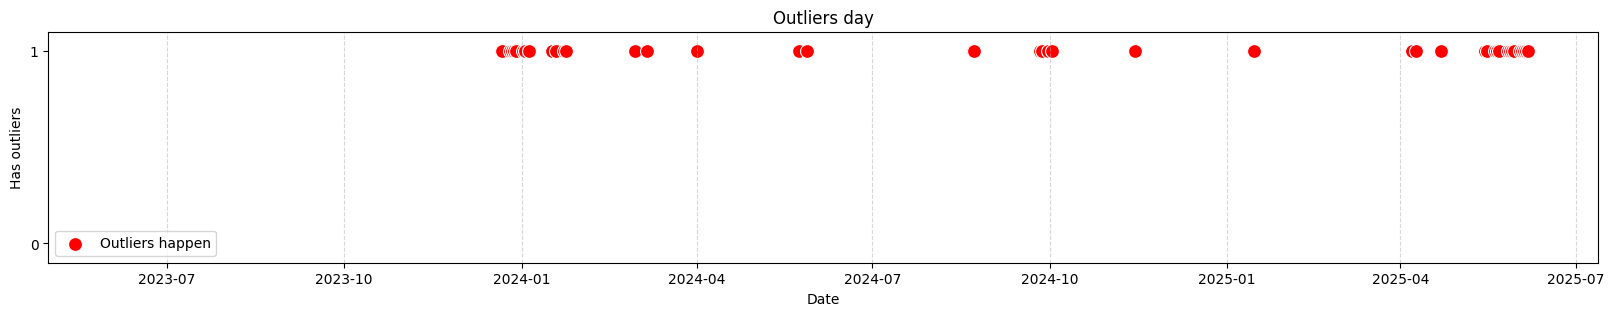

In [121]:
TradeHistory['Has outliers'] = -1
TradeHistory.loc[outliers_sum.index, 'Has outliers'] = 1

plt.figure(figsize=(20, 3))
sns.scatterplot(data=TradeHistory, x=TradeHistory.index, y='Has outliers', color='red' , marker='o', s=100, label='Outliers happen')
plt.yticks(np.arange(0, 2, 1))
plt.ylim(-0.1, 1.1)
plt.title("Outliers day")
plt.xlabel("Date")
plt.ylabel("Has outliers")
plt.legend(loc = 'lower left')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

Để đơn giản, chúng ta có thể sử dụng [Capping](https://www.supermoney.com/encyclopedia/capping-meaning) cho các outliers xảy ra chỉ 1 ngày, vì chúng ta có giả định rằng bất kỳ sự kiện lớn nào ảnh hưởng đến giá trị cổ phiếu đều phải kéo dài ít nhất hơn 1 ngày, hoặc có khoảng thời gian là 15 ngày.

Chúng ta sẽ đặt các điểm outliers 1 ngày về cận dưới hoặc cận trên, tùy theo giá trị nào gần hơn.

In [148]:
# add a new column to check for nearby outliers
outliers_sum['Real outliers'] = False
dates = outliers_sum.index

# flagging first and last outliers as True
outliers_sum.iloc[0, outliers_sum.columns.get_loc('Real outliers')] = True
outliers_sum.iloc[-1, outliers_sum.columns.get_loc('Real outliers')] = True

for i in range(1, len(dates)-1):
    current_date = dates[i]
    future_date = current_date + timedelta(days=15)
    past_date = current_date - timedelta(days=15)
    if (dates[i+1] <= future_date) or (dates[i-1] >= past_date):
        outliers_sum.at[dates[i], 'Real outliers'] = True

not_real_outliers = outliers_sum[outliers_sum['Real outliers'] == False]

for date in not_real_outliers.index:
    need_fixed = not_real_outliers.loc[date]['Outlier'].split(',')
    up = []
    low = []
    for cause in need_fixed:
        up.append(bound_dict[cause][1])
        low.append(bound_dict[cause][0])
    for s in range(len(need_fixed)):
        TradeHistory.loc[date, "Has outliers"] = -1
        if abs(TradeHistory.loc[date, need_fixed[s]] - up[s]) > abs(TradeHistory.loc[date, need_fixed[s]] - low[s]):
            TradeHistory.loc[date, need_fixed[s]] = low[s]
        else:
            TradeHistory.loc[date, need_fixed[s]] = up[s]
    outliers_sum.drop(index=date, inplace=True)
    
print(up, low)
    
outliers_sum
    

[np.float64(3088775.0)] [np.float64(-380225.0)]


,Outlier Open,Outlier High,Outlier Low,Outlier Close,Outlier Volume,Outlier,Open,High,Low,Close,Volume,Real outliers
Date,,,,,,,,,,,,
2023-12-22 00:00:00-05:00,False,False,False,False,True,Volume,78.535415,86.637970,77.864994,83.937119,21186700,True
2023-12-26 00:00:00-05:00,False,False,False,False,True,Volume,88.304443,90.468958,87.308391,88.304443,8078200,True
2023-12-27 00:00:00-05:00,False,False,False,False,True,Volume,84.779932,85.689798,83.429510,83.927536,7497500,True
2023-12-28 00:00:00-05:00,False,False,False,False,True,Volume,86.139944,87.365861,85.383321,85.526985,3372100,True
2023-12-29 00:00:00-05:00,False,False,False,False,True,Volume,88.065017,90.152910,87.404175,89.223900,5088600,True
2024-01-02 00:00:00-05:00,False,False,False,False,True,Volume,88.112906,89.041924,87.547838,88.563049,3103700,True
2024-01-03 00:00:00-05:00,False,False,False,False,True,Volume,89.664461,92.461086,88.610931,92.145027,3158800,True
2024-01-05 00:00:00-05:00,False,False,False,False,True,Volume,89.741080,89.750660,87.327556,87.337135,3146400,True
2024-01-17 00:00:00-05:00,False,False,False,False,True,Volume,82.366409,84.655428,82.174862,84.636276,3357100,True


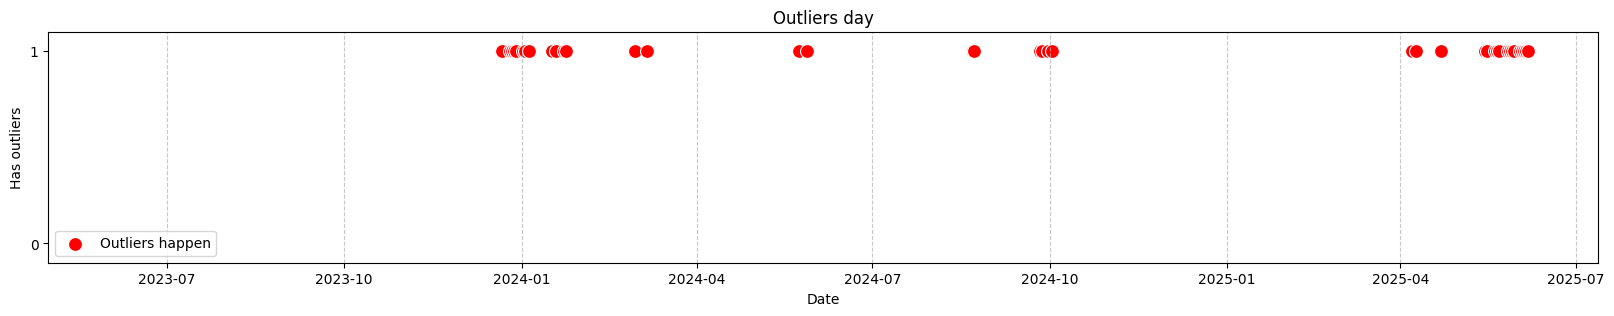

In [123]:
plt.figure(figsize=(20, 3))
sns.scatterplot(data=TradeHistory, x=TradeHistory.index, y='Has outliers', color='red' , marker='o', s=100, label='Outliers happen')
plt.yticks(np.arange(0, 2, 1))
plt.ylim(-0.1, 1.1)
plt.title("Outliers day")
plt.xlabel("Date")
plt.ylabel("Has outliers")
plt.legend(loc = 'lower left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## **Phần 2: Tính toán chỉ số kỹ thuật cơ bản**

Chỉ số [SMA](https://www.investopedia.com/terms/s/sma.asp), [EMA](https://www.investopedia.com/terms/e/ema.asp), [RSI](https://www.investopedia.com/terms/r/rsi.asp)

### 1. Đường Trung bình Động Đơn giản 20 phiên (SMA 20)

$$
SMA_{20} = \frac{P_1 + P_2 + ... + P_{20}}{20}
$$

Trong đó:
* $P_i$ là giá đóng cửa của phiên giao dịch thứ $i$.

---

### 2. Đường Trung bình Động Đơn giản 50 phiên (SMA 50)

$$
SMA_{50} = \frac{P_1 + P_2 + ... + P_{50}}{50}
$$

Trong đó:
* $P_i$ là giá đóng cửa của phiên giao dịch thứ $i$.

---

### 3. Đường Trung bình Động Hàm mũ 20 phiên (EMA 20)

$$
EMA_{20, t} = (P_t - EMA_{20, t-1}) \times Multiplier + EMA_{20, t-1}
$$

Trong đó:

* $P_t$ là giá đóng cửa của phiên hiện tại.
* $EMA_{20, t-1}$ là giá trị EMA 20 của phiên trước đó.
* $Multiplier = \frac{2}{20 + 1} = \frac{2}{21} \approx 0.0952$

---

### 4. Chỉ số Sức mạnh Tương đối 14 phiên (RSI 14)

$$
RSI_{14} = 100 - \frac{100}{1 + RS_{14}}
$$

Trong đó:
$$
RS_{14} = \frac{Average\ Gain_{14}}{Average\ Loss_{14}}
$$

* $Average\ Gain_{14}$: Trung bình của các mức tăng giá trong 14 phiên.
* $Average\ Loss_{14}$: Trung bình của các mức giảm giá (lấy giá trị tuyệt đối) trong 14 phiên.

---

In [124]:
# we will add 50 trade days before 06-06-2023 to TradeHistory for percise calculation
TradeHistory_prev =  NTES_stockData.history(start="2023-03-24", end="2023-06-06")
TradeHistory_prev.shape

(50, 7)

In [125]:
#perform data filter
print(TradeHistory_prev.isnull().sum()) # no null value
print((TradeHistory_prev['Volume'] < 0).sum()) # no negative volume

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64
0


In [126]:
# we will add 50 days before 06-06-2023 to TradeHistory for percise SMA and calculating
TradeHistory = pd.concat([TradeHistory_prev, TradeHistory]).sort_index()
TradeHistory['SMA 20'] = TradeHistory['Close'].rolling(window=20).mean() # SMA 20
TradeHistory['SMA 50'] = TradeHistory['Close'].rolling(window=50).mean() #SMA 50
TradeHistory['EMA 20'] = TradeHistory['Close'].ewm(span=20, adjust=False).mean() #EMA 20
delta = TradeHistory['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14, min_periods=14).mean()
avg_loss = loss.rolling(window=14, min_periods=14).mean()
rs = avg_gain/avg_loss
rsi = 100 - (100/(1 + rs))
TradeHistory['RSI 14'] = rsi # RSI-14

TradeHistory_prev = TradeHistory.iloc[:50].copy()
TradeHistory = TradeHistory.iloc[50:].copy() #cut all the part that we won't analysis
TradeHistory

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Has outliers,SMA 20,SMA 50,EMA 20,RSI 14
Date,,,,,,,,,,,,
2023-06-06 00:00:00-04:00,83.022243,86.485827,82.644739,86.240448,1317400,0.000,0.0,-1.0,82.266288,83.538848,82.468366,53.333333
2023-06-07 00:00:00-04:00,86.080003,88.684772,86.080003,86.278191,978600,0.000,0.0,-1.0,82.459286,83.596794,82.831207,56.586933
2023-06-08 00:00:00-04:00,86.529562,87.620432,86.529562,87.459167,526100,0.465,0.0,-1.0,82.644798,83.634192,83.271965,61.357490
2023-06-09 00:00:00-04:00,88.540549,88.806158,87.373799,87.554031,998200,0.000,0.0,-1.0,82.851569,83.717090,83.679781,60.900939
2023-06-12 00:00:00-04:00,87.487649,88.844120,87.487649,88.569031,552100,0.000,0.0,-1.0,83.260563,83.816323,84.145424,60.861813
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-02 00:00:00-04:00,122.309998,123.480003,122.269997,123.199997,801100,0.000,0.0,1.0,115.168910,106.452380,116.401867,75.298764
2025-06-03 00:00:00-04:00,125.809998,126.500000,125.379997,126.059998,1882700,0.000,0.0,1.0,116.011730,107.043123,117.321689,78.137838
2025-06-04 00:00:00-04:00,126.500000,127.669998,126.489998,127.220001,942500,0.000,0.0,1.0,116.953825,107.599779,118.264386,78.410309


In [127]:
#checking if any RSI 14 value does not fit in [0,100]
mask = (TradeHistory['RSI 14'] > 100) | (TradeHistory['RSI 14'] < 0)
TradeHistory[mask]
#we can see that all the RSI 14 value is fit in [0,100] as we should expect

#export TradeHistory to csv file
TradeHistory.to_csv('NTES_TradeHistory_post_cleaning.csv')

## **Phần 3: Phân tích dữ liệu kết hợp Trực quan hóa dữ liệu**

# Tính lợi suất ngày, phân phối lợi suất và Biểu đồ histogram của lợi suất.

$$ \text{Lợi suất ngày}_t = \frac{(\text{Giá đóng cửa}_t - \text{Giá mở cửa}_t)}{\text{Giá mở cửa}_t} \times 100\% $$

Trong đó:
* $ \text{Lợi suất ngày}_t $: Lợi suất của ngày $t$
* $ \text{Giá đóng cửa}_t $: Giá đóng cửa của ngày $t$
* $ \text{Giá mở cửa}_t $: Giá mở cửa của ngày $t$

In [128]:
# we will calculate Rate of return for each days
TradeHistory['Daily return'] = (TradeHistory['Close'] - TradeHistory['Open'])/TradeHistory['Open']
TradeHistory

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Has outliers,SMA 20,SMA 50,EMA 20,RSI 14,Daily return
Date,,,,,,,,,,,,,
2023-06-06 00:00:00-04:00,83.022243,86.485827,82.644739,86.240448,1317400,0.000,0.0,-1.0,82.266288,83.538848,82.468366,53.333333,0.038763
2023-06-07 00:00:00-04:00,86.080003,88.684772,86.080003,86.278191,978600,0.000,0.0,-1.0,82.459286,83.596794,82.831207,56.586933,0.002302
2023-06-08 00:00:00-04:00,86.529562,87.620432,86.529562,87.459167,526100,0.465,0.0,-1.0,82.644798,83.634192,83.271965,61.357490,0.010743
2023-06-09 00:00:00-04:00,88.540549,88.806158,87.373799,87.554031,998200,0.000,0.0,-1.0,82.851569,83.717090,83.679781,60.900939,-0.011142
2023-06-12 00:00:00-04:00,87.487649,88.844120,87.487649,88.569031,552100,0.000,0.0,-1.0,83.260563,83.816323,84.145424,60.861813,0.012360
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-02 00:00:00-04:00,122.309998,123.480003,122.269997,123.199997,801100,0.000,0.0,1.0,115.168910,106.452380,116.401867,75.298764,0.007277
2025-06-03 00:00:00-04:00,125.809998,126.500000,125.379997,126.059998,1882700,0.000,0.0,1.0,116.011730,107.043123,117.321689,78.137838,0.001987
2025-06-04 00:00:00-04:00,126.500000,127.669998,126.489998,127.220001,942500,0.000,0.0,1.0,116.953825,107.599779,118.264386,78.410309,0.005692


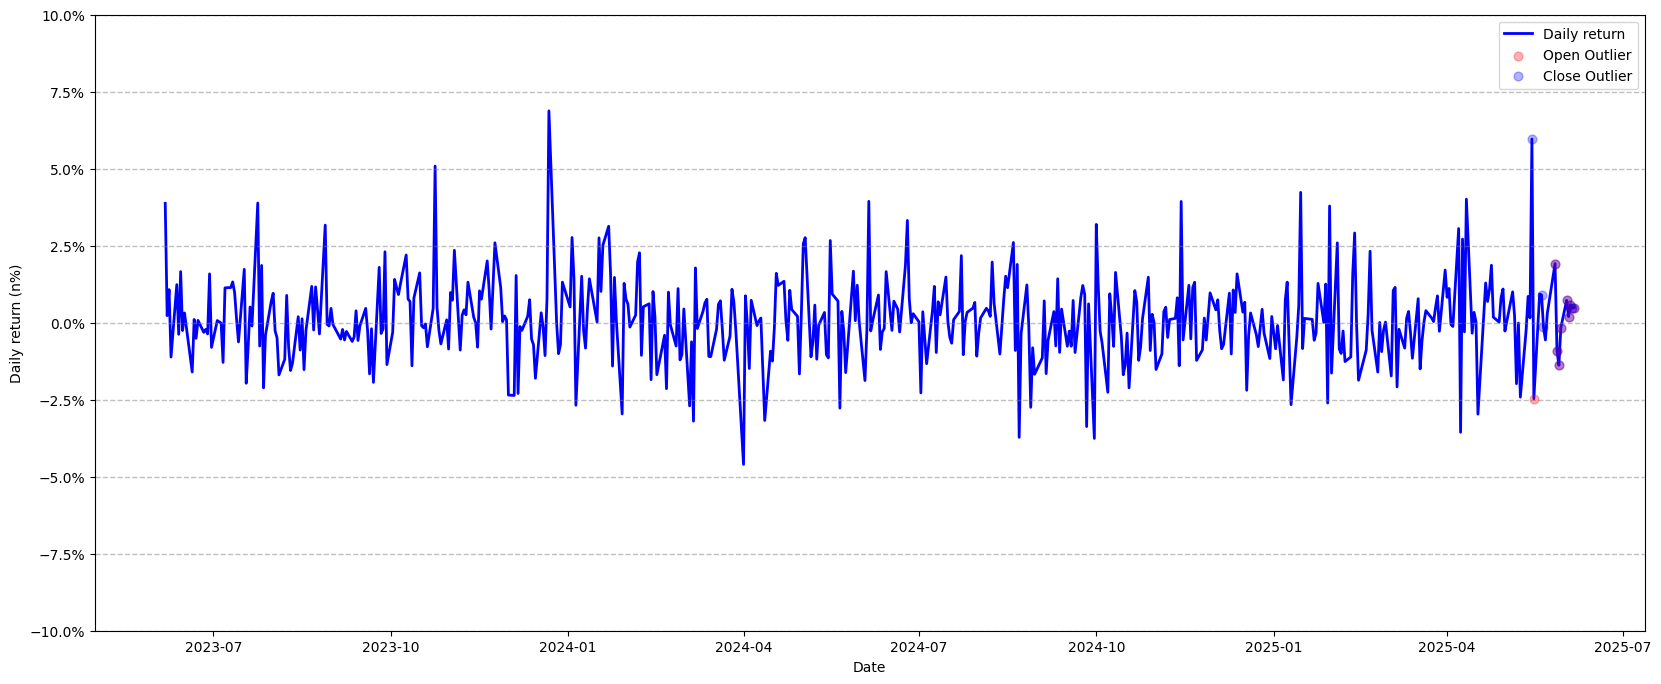

In [129]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.lineplot(data=TradeHistory, x=TradeHistory.index, y='Daily return', label='Daily return', color='blue', linewidth=2, ax=ax)
ax.set_ylabel('Daily return (n%)')
ax.set_ylim(-0.1, 0.1)
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))

# add outlier scatter plot made by Open and Close
outlier_dates = outliers_sum.index
open_outlier_mask = outliers_sum['Outlier Open'] == True
close_outlier_mask = outliers_sum['Outlier Close'] == True
ax.scatter(x=outliers_sum.index[open_outlier_mask], y= TradeHistory.loc[outliers_sum.index[open_outlier_mask], 'Daily return'], color='red', label='Open Outlier', s=40, marker='o', zorder=3, alpha=0.3)
ax.scatter(x= outliers_sum.index[close_outlier_mask], y= TradeHistory.loc[outliers_sum.index[close_outlier_mask], 'Daily return'], color='blue', label='Close Outlier', s=40, marker='o', zorder=3, alpha=0.3)
for val in [0, 0.025, 0.05, 0.075, 0.10, -0.025, -0.05, -0.075, -0.10]:
    ax.axhline(val, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.legend()

Dựa vào biểu đồ, chúng ta có thể chia Tỷ suất sinh lời hàng ngày thành 21 khoảng, từ -10% đến 10% mà không làm mất bất kỳ dữ liệu nào.

Bây giờ chúng ta sẽ kiểm tra Phân phối lãi suất.

503


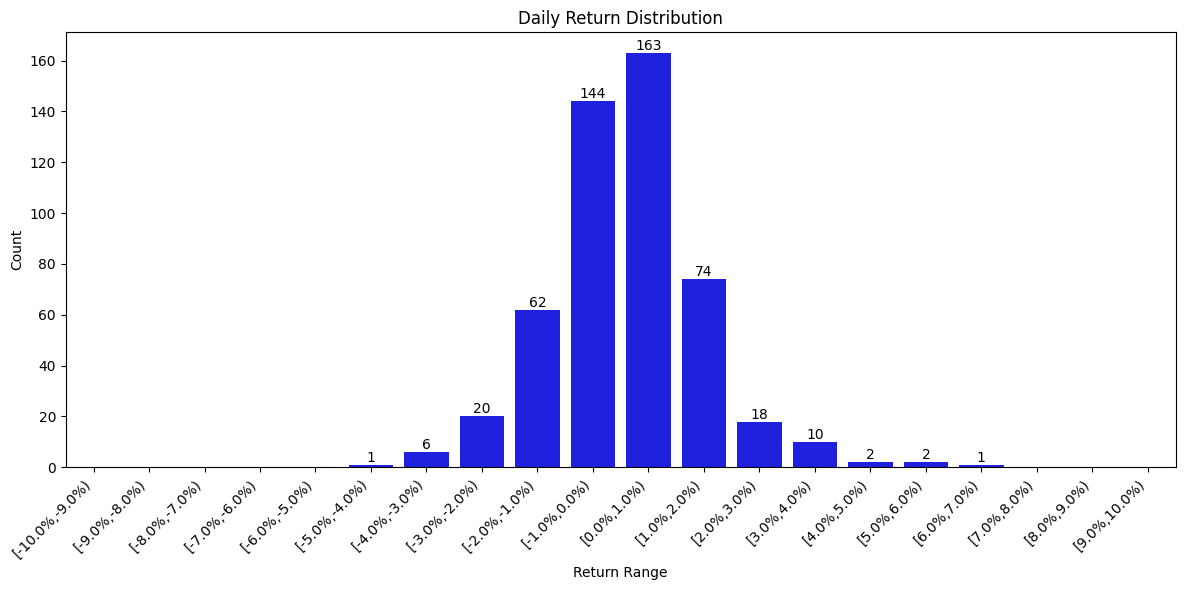

In [130]:
bins_count = np.linspace(-0.1, 0.1, 21)

labels = []
for i in range(len(bins_count) - 1):
    lower_pct_str = f"{bins_count[i]*100:.1f}"
    upper_pct_str = f"{bins_count[i+1]*100:.1f}"
    labels.append(f"[{lower_pct_str}%,{upper_pct_str}%)")

return_dist = pd.cut(TradeHistory['Daily return'], bins=bins_count, labels=labels, include_lowest=True, right=False)
distribution = return_dist.value_counts().sort_index().reset_index()
distribution.columns = ['Return Range', 'Count']
print(distribution['Count'].sum())

# graph out
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=distribution, x='Return Range', y='Count', color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Daily Return Distribution')
plt.xlabel('Return Range')
plt.ylabel('Count')
for con in ax.containers:
    for bar in con:
        height = bar.get_height()
        if height > 0:
            ax.text(x = bar.get_x() + bar.get_width()/2, y= height, s= height.astype(int), ha='center',va='bottom')
plt.tight_layout()
plt.show()

Bây giờ chúng ta sẽ tính toán tất cả các chỉ số của Phân phối lãi suất ngày.

In [131]:
# Calculate statistics for Daily return
daily_return = TradeHistory['Daily return']

stats = {
    'Mean': daily_return.mean(),
    'Median': daily_return.median(),
    'Std': daily_return.std(),
    'Min': daily_return.min(),
    'Max': daily_return.max(),
    'Skewness': daily_return.skew(),
    'Kurtosis': daily_return.kurtosis(),
    '25% Quantile': daily_return.quantile(0.25),
    '75% Quantile': daily_return.quantile(0.75),
    'IQR': daily_return.quantile(0.75) - daily_return.quantile(0.25)
}

stats_df = pd.DataFrame(stats, index=['Value']).T
print(stats_df)

                 Value
Mean          0.001045
Median        0.000550
Std           0.013740
Min          -0.046004
Max           0.068780
Skewness      0.481012
Kurtosis      2.427668
25% Quantile -0.007093
75% Quantile  0.008200
IQR           0.015293


Nhìn vào thống kê Phân phối này, chúng ta có thể thấy rằng cổ phiếu này không ổn định.

Lý do cho điều đó:

- Trong 2 năm, nó có nhiều thay đổi lớn, từ rất thấp (-5.0% đến -4.0%) đến rất cao (7.0% đến 8.0%).
- Cổ phiếu có độ biến động lãi suất ngày lớn (13%), so với các cổ phiếu của công ty ổn định như Coca-Cola, chỉ 6%.
- Giá trị độ lệch chuẩn (std) cao so với giá trị trung bình (mean), điều này cho thấy giá trị lãi suất ngày không tập trung.

Mặc dù vậy, chúng ta chưa thể xác nhận sự thiếu ổn định. Ở phần sau, chúng ta sẽ chứng minh điều đó.

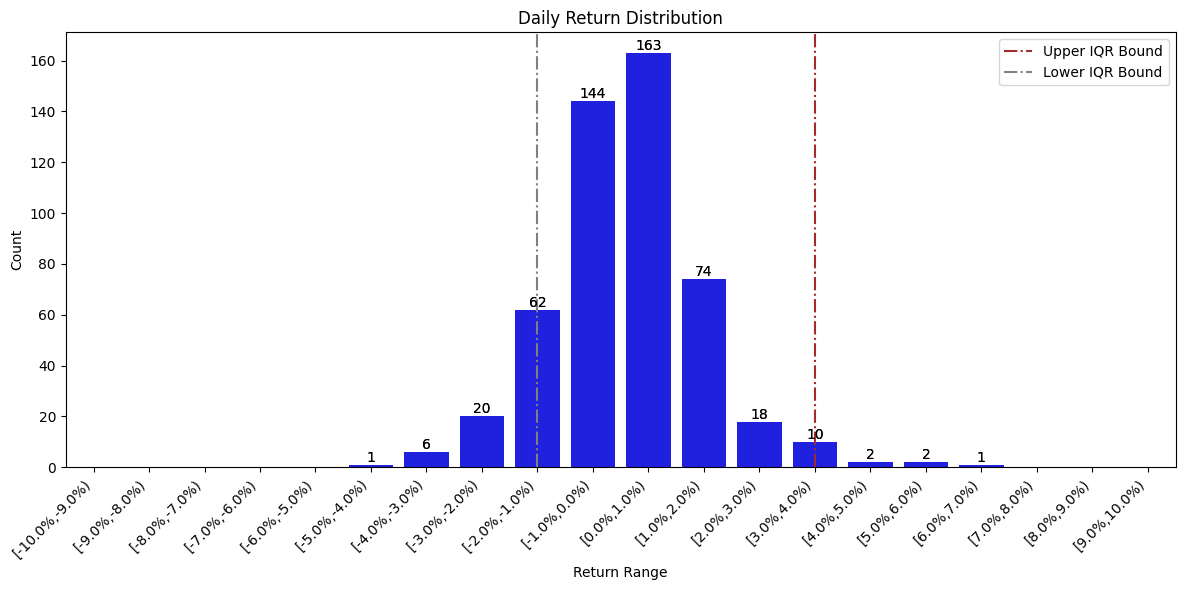

In [132]:
Q1_1 = TradeHistory['Daily return'].quantile(0.25)
Q3_1 = TradeHistory['Daily return'].quantile(0.75)
IQR_1 = Q3_1 - Q1_1
upper_bound_1 = Q3_1 + IQR_1*1.5
lower_bound_1 = Q3_1 - IQR_1*1.5

#a special value for stability
TradeHistory['Daily fluctuation'] = (TradeHistory['High'] - TradeHistory['Low'])/ TradeHistory['Close']

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=distribution, x='Return Range', y='Count', color='blue')
ax = sns.barplot(data=distribution, x='Return Range', y='Count', color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Daily Return Distribution')
plt.xlabel('Return Range')
plt.ylabel('Count')
for con in ax.containers:
    for bar in con:
        height = bar.get_height()
        if height > 0:
            ax.text(x = bar.get_x() + bar.get_width()/2, y= height, s= height.astype(int), ha='center',va='bottom')
plt.tight_layout()
upper_bin = np.searchsorted(a=bins_count, v=upper_bound_1) -1
lower_bin = np.searchsorted(a=bins_count, v= lower_bound_1) -1

plt.axvline(x=upper_bin, color='brown', linestyle='-.', label='Upper IQR Bound')
plt.axvline(x=lower_bin, color='gray', linestyle='-.', label='Lower IQR Bound')
plt.legend()
plt.show()

Từ biểu đồ phía trên, chúng ta có thể thấy rõ một số outliers cực lớn, vượt ra ngoài giới hạn dưới/trên.

Chúng ta sẽ tiến hành kiểm tra các outliers này.

In [133]:
daily_return_outliers = TradeHistory[(((TradeHistory['Daily return'] >= -0.05) & (TradeHistory['Daily return'] < -0.02)) |((TradeHistory['Daily return'] >= 0.04) & (TradeHistory['Daily return'] < 0.07)))]
daily_return_outliers

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Has outliers,SMA 20,SMA 50,EMA 20,RSI 14,Daily return,Daily fluctuation
Date,,,,,,,,,,,,,,
2023-07-27 00:00:00-04:00,103.689404,103.850669,101.090294,101.498184,606200,0.00,0.0,-1.0,96.674169,90.271780,97.063926,73.392496,-0.021133,0.027196
2023-10-24 00:00:00-04:00,96.187250,102.499921,96.187250,101.079094,1154500,0.00,0.0,-1.0,97.823112,96.802895,98.192692,63.665463,0.050858,0.062453
2023-12-01 00:00:00-05:00,107.277452,107.880831,104.499979,104.758568,1968600,0.00,0.0,-1.0,108.809512,102.725261,107.690240,40.706000,-0.023480,0.032273
2023-12-04 00:00:00-05:00,102.191806,102.191806,99.490955,99.778282,1992000,0.00,0.0,-1.0,108.424070,102.778582,106.936721,29.509387,-0.023618,0.027069
2023-12-06 00:00:00-05:00,100.534909,100.956321,98.121377,98.226730,1521100,0.00,0.0,-1.0,107.604390,102.877912,105.370707,26.408892,-0.022959,0.028861
2023-12-22 00:00:00-05:00,78.535415,86.637970,77.864994,83.937119,21186700,0.00,0.0,1.0,100.968743,103.238100,99.899468,23.391310,0.068780,0.104518
2024-01-05 00:00:00-05:00,89.741080,89.750660,87.327556,87.337135,3146400,0.00,0.0,1.0,94.506837,101.551402,93.709005,35.681887,-0.026788,0.027744
2024-01-29 00:00:00-05:00,97.996865,98.063907,94.098827,95.094887,2307000,0.00,0.0,-1.0,89.652964,96.884031,91.954736,67.075861,-0.029613,0.041696
2024-02-21 00:00:00-05:00,104.614916,104.614916,101.789552,102.373779,2527600,0.00,0.0,-1.0,99.423437,94.681911,99.370915,66.848815,-0.021423,0.027599


Giờ ta so sánh với outliers dataframe trước đó để kiểm tra các giao điểm của 2 loại Outliers.

In [150]:
common_dates = daily_return_outliers.index.intersection(outliers_sum.index)
for date in common_dates:
    print(date)

2023-12-22 00:00:00-05:00
2024-01-05 00:00:00-05:00
2024-03-06 00:00:00-05:00
2024-08-22 00:00:00-04:00
2024-09-26 00:00:00-04:00
2024-09-30 00:00:00-04:00
2025-05-15 00:00:00-04:00
2025-05-16 00:00:00-04:00


Vẽ biểu đồ từ 3 loại: outliers lãi , outliers thường, và cả điểm outliers chung.

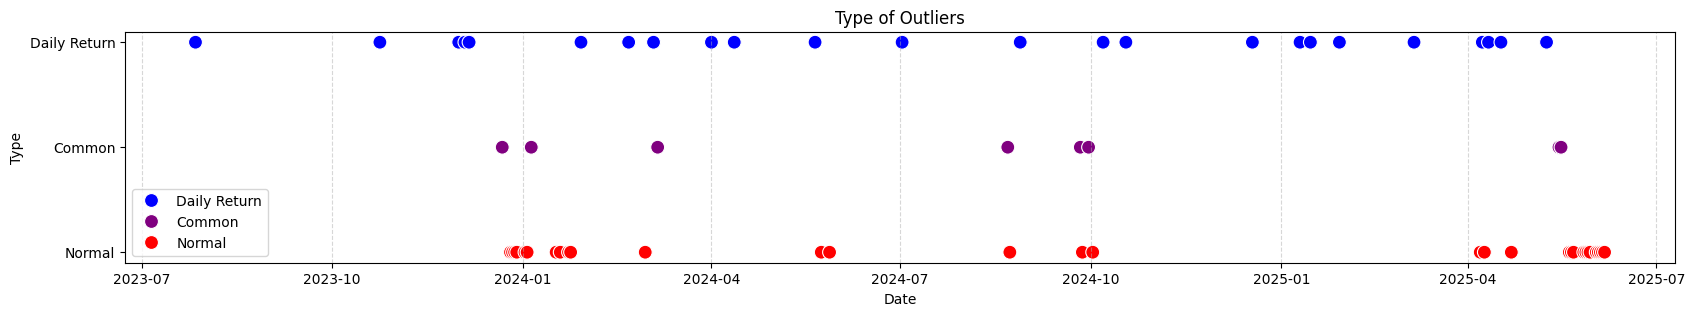

In [135]:
outliers_type_df = pd.DataFrame(index= outliers_sum.index.union(daily_return_outliers.index), columns=['Type'])
outliers_type_df.loc[outliers_sum.index, 'Type'] = 'Normal'
outliers_type_df.loc[daily_return_outliers.index, 'Type'] = 'Daily Return'
outliers_type_df.loc[common_dates, 'Type'] = 'Common'
outliers_type_df = outliers_type_df.sort_index()
outliers_type_df
# plot the scatter plot of type of outliers
plt.figure(figsize=(20, 3))
sns.scatterplot(data=outliers_type_df, x=outliers_type_df.index, y='Type', hue='Type',palette={'Normal': 'red', 'Daily Return': 'blue', 'Common': 'purple'}, markers='o', s=100)
plt.title("Type of Outliers")
plt.xlabel("Date")
plt.ylabel("Type")
plt.legend(loc='lower left')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


Nhìn vào biểu đồ này, chúng ta có thể nhận thấy rằng các outliers của Lợi nhuận hàng ngày rất phân tán, trong khi điểm outliers chung và điểm outliers thường lại có mối liên hệ chặt chẽ với nhau hơn.

Do đó, chúng ta nên tập trung phân tích outliers thường và outliers chung.

Quay trở lại với các outliers chung, chúng ta có thể thấy rằng một số thay đổi lớn đã xuất hiện trong các tháng sau:

Tháng 12/2023 - Tháng 01/2024

Tháng 03/2024

Tháng 08/2024

Tháng 09/2024

Tháng 05/2025 - Tháng 06/2025

Bây giờ chúng ta sẽ tìm hiểu các giai đoạn này để xem những sự kiện nào đã tạo ra những thay đổi này.

In [136]:
import finnhub ##to get news data
import time

FINNHUB_API_KEY = "d192c1hr01qkcat5km0gd192c1hr01qkcat5km10"

finnhub_client = finnhub.Client(api_key=FINNHUB_API_KEY)
#list of periods to fetch news data
periods = [('2023-12-01', '2024-01-31'),('2024-03-01', '2024-03-31'),('2024-08-01', '2024-08-31'),('2024-09-01', '2024-09-30'),('2025-05-01', '2025-06-06')]

symbol = "NTES"

all_news_data = []
request_count = 0

for start_date, end_date in periods:
    news_items = finnhub_client.company_news(symbol, _from=start_date, to=end_date)
    request_count += 1

    if news_items:
        processed_news = []
        for item in news_items:
            processed_news.append({
                'datetime': pd.to_datetime(item.get('datetime'), unit='s'),
                'category': item.get('category'),
                'headline': item.get('headline'),
                'id': item.get('id'),
                'image': item.get('image'),
                'related': item.get('related'),
                'source': item.get('source'),
                'summary': item.get('summary'),
                'url': item.get('url')})
            all_news_data.extend(processed_news)

    else:
        print("no news found for the period from", start_date, "to", end_date)

    if request_count % 25 == 0:
        time.sleep(5) #limit to 25 requests per minute
    else:
        time.sleep(0.5)

final_news_df = pd.DataFrame()

final_news_df = pd.DataFrame(all_news_data)
final_news_df = final_news_df.drop_duplicates(subset=['id']).set_index('datetime').sort_index()

csv_file_name = f"{symbol}_news_data.csv"
final_news_df.to_csv(csv_file_name)
final_news_df

no news found for the period from 2023-12-01 to 2024-01-31
no news found for the period from 2024-03-01 to 2024-03-31


,category,headline,id,image,related,source,summary,url
datetime,,,,,,,,
2024-08-01 07:42:00,company,Dodge & Cox Emerging Markets Stock Fund Q2 202...,129063060,https://static.seekingalpha.com/cdn/s3/uploads...,NTES,SeekingAlpha,The first half of 2024 underscored the breadth...,https://finnhub.io/api/news?id=8546f453a9ff0a6...
2024-08-02 09:26:00,company,"U.S. video game spending fell 5% y/y in June, ...",129102968,,NTES,Thefly.com,Looking for stock market analysis and research...,https://finnhub.io/api/news?id=1080bfc482f82c4...
2024-08-02 09:30:00,company,"Tencent, NetEase win big with Rainbow Six and ...",129104364,https://s.yimg.com/cv/apiv2/social/images/yaho...,NTES,Yahoo,China's video game regulator has approved anot...,https://finnhub.io/api/news?id=e0f8ab7aaa99b57...
2024-08-05 04:30:00,company,Youdao to Report Second Quarter 2024 Financial...,129152641,,NTES,PR Newswire,Looking for stock market analysis and research...,https://finnhub.io/api/news?id=ac508c9a645f3aa...
2024-08-05 08:30:00,company,NetEase to Report Second Quarter 2024 Financia...,129149109,https://media.zenfs.com/en/prnewswire.com/f82d...,NTES,Yahoo,"NetEase, Inc. (NASDAQ: NTES and HKEX: 9999, ""N...",https://finnhub.io/api/news?id=d63b0fa6210b364...
...,...,...,...,...,...,...,...,...
2025-05-29 13:58:00,company,4 Solid Dividend Growth Stocks to Buy Now,134840025,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,NTES,Yahoo,"NTES, FOX, QFIN and UGI stand out as strong di...",https://finnhub.io/api/news?id=7f418492bcb974b...
2025-05-30 09:09:00,company,"Zacks.com featured highlights NetEase, Fox, Qi...",134894130,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,NTES,Yahoo,"NetEase, Fox, Qifu Technology and UGI make the...",https://finnhub.io/api/news?id=5b2aadac9380865...
2025-06-03 12:53:12,company,Top 50 High-Quality Dividend Stocks For June 2025,134980969,https://static.seekingalpha.com/cdn/s3/uploads...,NTES,SeekingAlpha,Track 50 top dividend growth stocks with daily...,https://finnhub.io/api/news?id=019d2eb701e479e...


Chúng ta sẽ xem các tin tức sẽ ảnh hưởng giá cổ phiếu như nào.

In [137]:
categories_keywords = {
    "Game Performance": [
        "new titles", "user numbers", "engagement", "monetization", "pc gaming",
        "mobile gaming", "game launch", "player count", "revenue per user", "DAU",
        "MAU", "ARPPU", "ARPU", "download", "sales figures", "game growth",
        "game performance", "title success", "game releases", "active users",
        "player engagement", "in-game purchase", "microtransaction"
    ],
    "Strategic Moves": [
        "partnerships", "acquisitions", "international expansion", "joint venture",
        "merger", "investment", "expansion", "new market", "global strategy",
        "collaboration", "strategic alliance", "subsidiary", "divestment", "deal",
        "agreement"
    ],
    "Financials": [
        "revenue", "profit", "R&D investment", "earnings", "quarterly results",
        "financial report", "net income", "gross margin", "expenditure", "share price",
        "stock performance", "dividend", "IPO", "valuation", "income", "expense",
        "balance sheet", "cash flow", "Q1", "Q2", "Q3", "Q4", "fiscal year", "forecast"
    ],
    "Regulatory Landscape": [
        "government policies", "regulatory", "china", "gaming sector", "license",
        "approval", "crackdown", "rules", "law", "policy changes", "ministry",
        "compliance", "regulations", "government", "censor", "ban", "restriction",
        "licensing"
    ]
}
def categorize_news(row):
    text_check = ""
    if 'summary' in row.index and pd.notna(row['summary']):
        text_check += str(row['summary']) + " "
    if 'headline' in row.index and pd.notna(row['headline']):
        text_check += str(row['headline'])

    text_check = text_check.lower()

    matched = []
    for category, keywords in categories_keywords.items():
        for keyword in keywords:
            if keyword.lower() in text_check:
                matched.append(category)
                break

    if not matched:
        return ["Other"]
    return matched

final_news_df['Categories'] = final_news_df.apply(categorize_news, axis=1)
final_news_df = final_news_df.explode('Categories')
final_news_df = final_news_df.reset_index()
final_news_df

,datetime,category,headline,id,image,related,source,summary,url,Categories
0,2024-08-01 07:42:00,company,Dodge & Cox Emerging Markets Stock Fund Q2 202...,129063060,https://static.seekingalpha.com/cdn/s3/uploads...,NTES,SeekingAlpha,The first half of 2024 underscored the breadth...,https://finnhub.io/api/news?id=8546f453a9ff0a6...,Financials
1,2024-08-02 09:26:00,company,"U.S. video game spending fell 5% y/y in June, ...",129102968,,NTES,Thefly.com,Looking for stock market analysis and research...,https://finnhub.io/api/news?id=1080bfc482f82c4...,Other
2,2024-08-02 09:30:00,company,"Tencent, NetEase win big with Rainbow Six and ...",129104364,https://s.yimg.com/cv/apiv2/social/images/yaho...,NTES,Yahoo,China's video game regulator has approved anot...,https://finnhub.io/api/news?id=e0f8ab7aaa99b57...,Regulatory Landscape
3,2024-08-05 04:30:00,company,Youdao to Report Second Quarter 2024 Financial...,129152641,,NTES,PR Newswire,Looking for stock market analysis and research...,https://finnhub.io/api/news?id=ac508c9a645f3aa...,Other
4,2024-08-05 08:30:00,company,NetEase to Report Second Quarter 2024 Financia...,129149109,https://media.zenfs.com/en/prnewswire.com/f82d...,NTES,Yahoo,"NetEase, Inc. (NASDAQ: NTES and HKEX: 9999, ""N...",https://finnhub.io/api/news?id=d63b0fa6210b364...,Other
...,...,...,...,...,...,...,...,...,...,...
119,2025-05-29 13:58:00,company,4 Solid Dividend Growth Stocks to Buy Now,134840025,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,NTES,Yahoo,"NTES, FOX, QFIN and UGI stand out as strong di...",https://finnhub.io/api/news?id=7f418492bcb974b...,Financials
120,2025-05-30 09:09:00,company,"Zacks.com featured highlights NetEase, Fox, Qi...",134894130,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,NTES,Yahoo,"NetEase, Fox, Qifu Technology and UGI make the...",https://finnhub.io/api/news?id=5b2aadac9380865...,Financials
121,2025-06-03 12:53:12,company,Top 50 High-Quality Dividend Stocks For June 2025,134980969,https://static.seekingalpha.com/cdn/s3/uploads...,NTES,SeekingAlpha,Track 50 top dividend growth stocks with daily...,https://finnhub.io/api/news?id=019d2eb701e479e...,Financials
122,2025-06-04 14:19:00,company,4 Stocks From the Tech Industry of China to Ke...,135013838,https://s.yimg.com/rz/stage/p/yahoo_finance_en...,NTES,Yahoo,Given China's technological strength and resil...,https://finnhub.io/api/news?id=64023d37e42e1ca...,Regulatory Landscape


Đếm các loại tin tức và vẽ chúng ra.

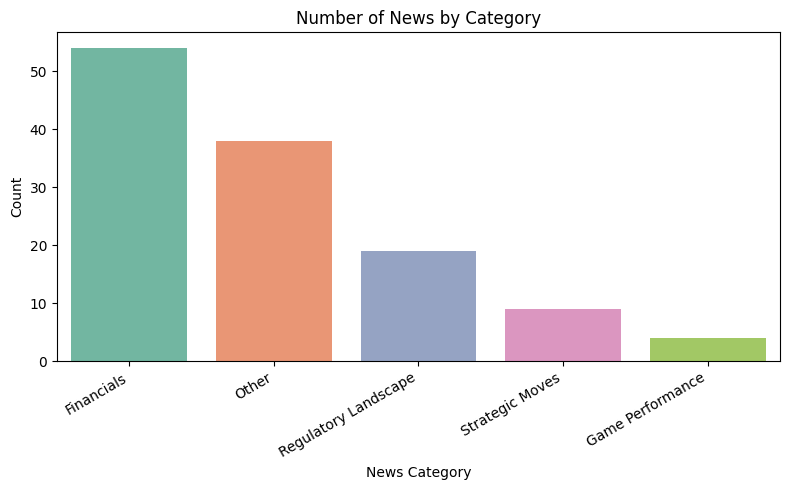

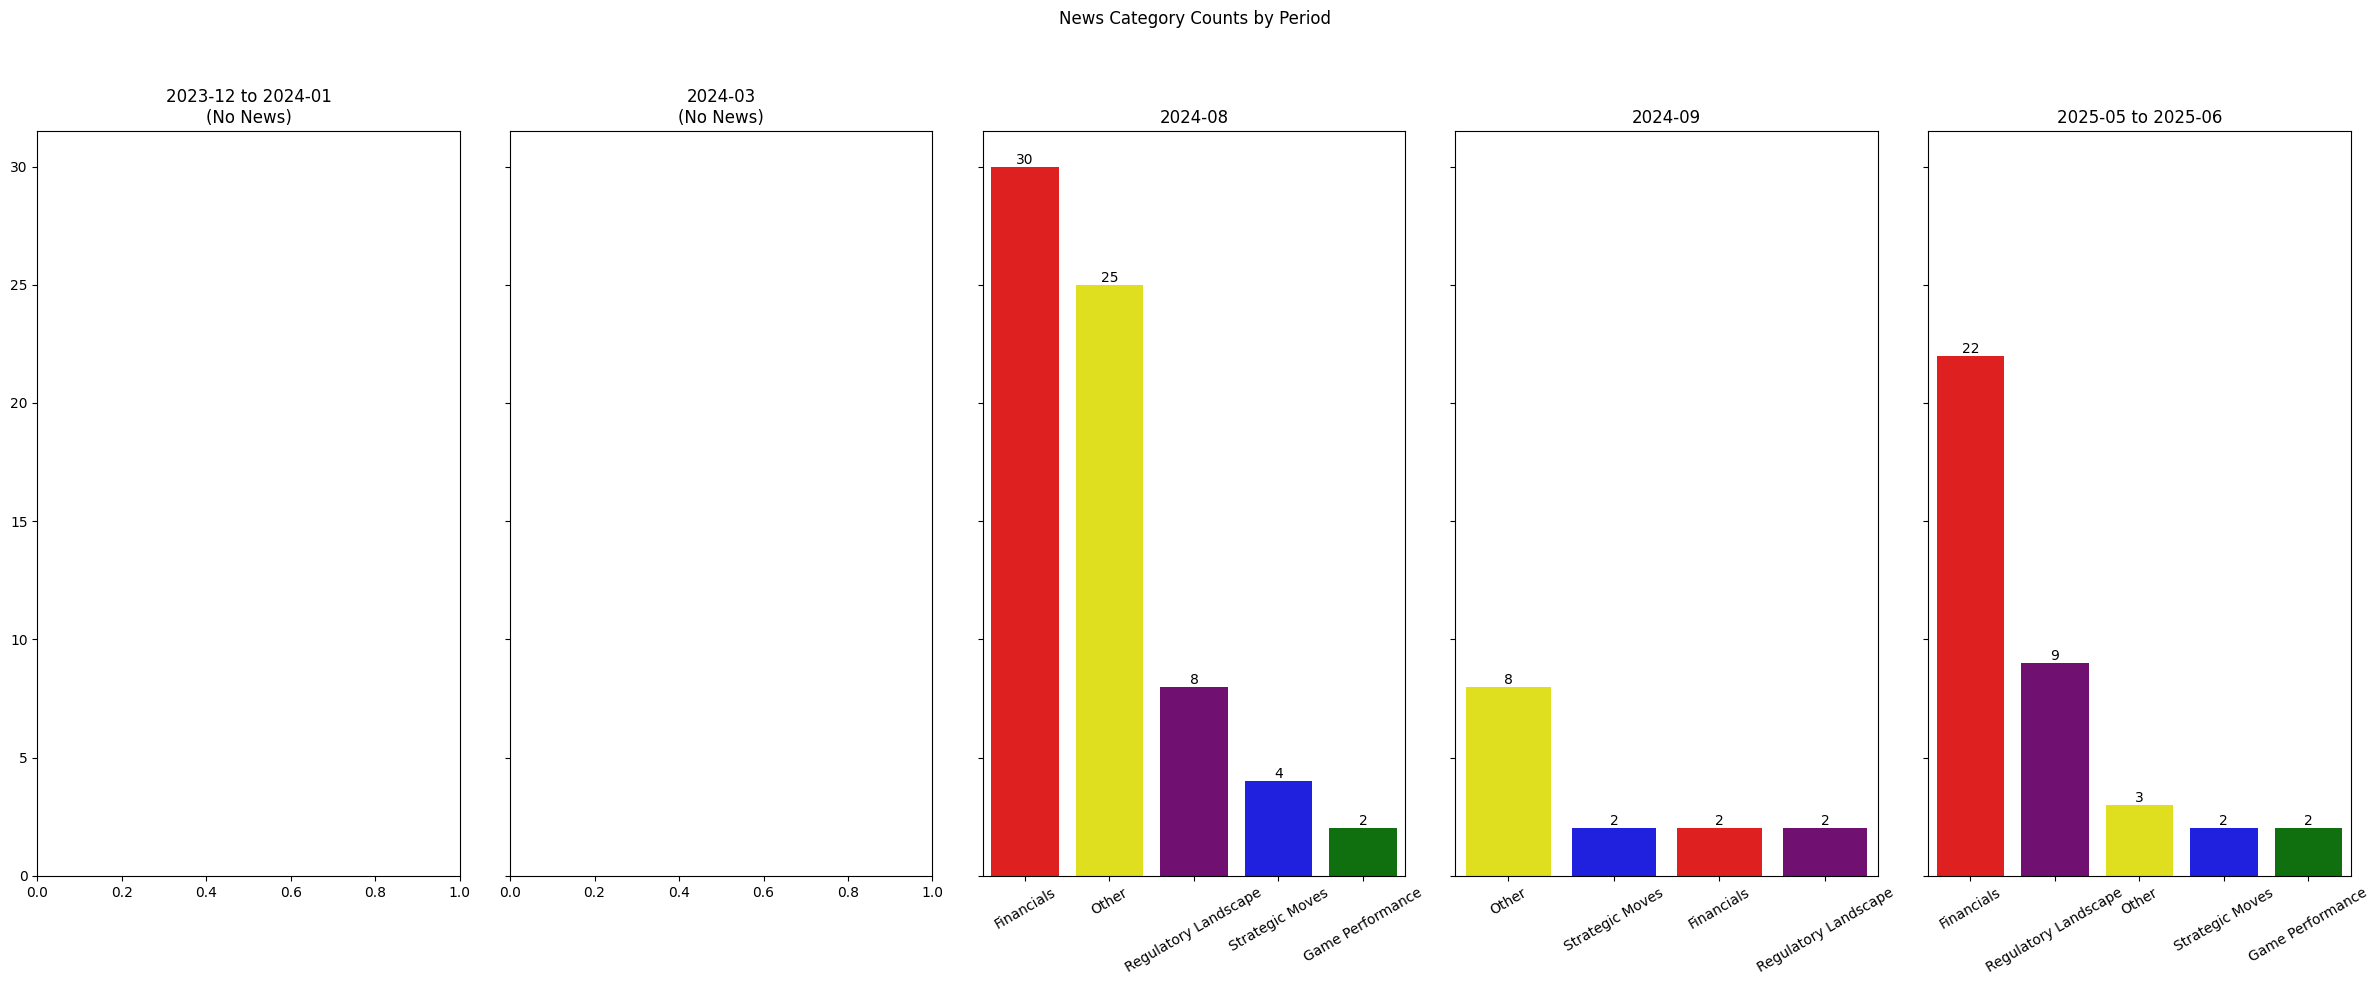

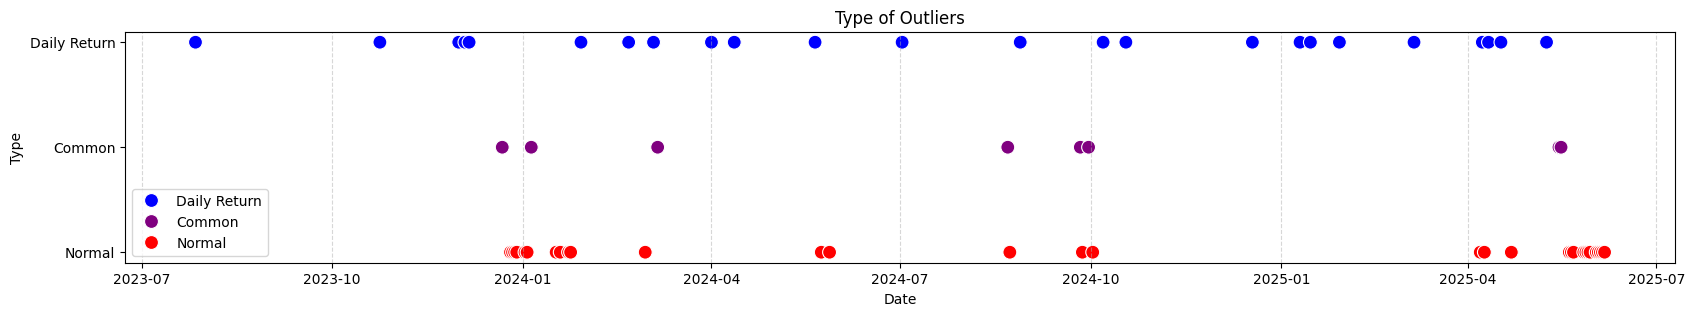

In [138]:
type_counts = final_news_df['Categories'].value_counts().reset_index()
type_counts.columns = ['Category', 'Count']

plt.figure(figsize=(8, 5))
sns.barplot(data=type_counts, x='Category', y='Count',hue="Category", palette='Set2')
plt.title('Number of News by Category')
plt.xlabel('News Category')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

#graph by our previos periods
periods = [
    ('2023-12-01', '2024-01-31', '2023-12 to 2024-01'),
    ('2024-03-01', '2024-03-31', '2024-03'),
    ('2024-08-01', '2024-08-31', '2024-08'),
    ('2024-09-01', '2024-09-30', '2024-09'),
    ('2025-05-01', '2025-06-06', '2025-05 to 2025-06')
]
category_palette = {
    "Financials": "red",
    "Other": "yellow",
    "Regulatory Landscape": "purple",
    "Strategic Moves": "blue",
    "Game Performance": "green"
}

fig, axes = plt.subplots(1, len(periods), figsize=(24, 10), sharey=True)
for ax, (start, end, title) in zip(axes, periods):
    mask = (final_news_df['datetime'] >= pd.to_datetime(start)) & (final_news_df['datetime'] <= pd.to_datetime(end))
    period_counts = final_news_df.loc[mask, 'Categories'].value_counts().reset_index()
    period_counts.columns = ['Category', 'Count']
    if not period_counts.empty:
        bars = sns.barplot(
            data=period_counts,
            x='Category',
            y='Count',
            hue='Category',
            palette=category_palette,
            ax=ax,
            legend=False
        )
        ax.set_title(title)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='x', rotation=30)
        # Add count labels to each bar
        for bar in bars.patches:
            height = bar.get_height()
            if height > 0:
                bars.annotate(f'{int(height)}', (bar.get_x() + bar.get_width()/2, height), ha='center', va='bottom', fontsize=10)
    else:  # skipping empty periods
        ax.set_title(f"{title}\n(No News)")
plt.suptitle('News Category Counts by Period')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

plt.figure(figsize=(20, 3))
sns.scatterplot(data=outliers_type_df, x=outliers_type_df.index, y='Type', hue='Type',palette={'Normal': 'red', 'Daily Return': 'blue', 'Common': 'purple'}, markers='o', s=100)
plt.title("Type of Outliers")
plt.xlabel("Date")
plt.ylabel("Type")
plt.legend(loc='lower left')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

Như chúng ta có thể thấy, mặc dù NetEase nổi tiếng với các trò chơi, nhưng giá cổ phiếu của họ dường như lại bị ảnh hưởng nhiều hơn bởi các tin tức liên quan đến tài chính, hay nói cách khác là doanh thu từ game và báo cáo lợi nhuận của họ, ví dụ tiêu biểu trong số đó [báo cáo quý 1 năm 2025](https://www.marketscreener.com/quote/stock/NETEASE-INC-111325397/news/NetEase-Q1-Earnings-Snapshot-49962037/#:~:text=HANGZHOU%2C%20China%20%28AP%29%20%E2%80%94%20HANGZHOU%2C%20China%20%28AP%29%20%E2%80%94,for%20stock%20option%20expense%2C%20were%20%242.41%20per%20share). Báo cáo đó đã tạo ra một mức tăng đột biến 15%, chủ yếu nhờ vào doanh thu từ game. Điều này có thể có nghĩa rằng niềm tin của các nhà đầu tư đặt vào kết quả tài chính hơn là sản phẩm của công ty.

# Phân tích bổ sung: Cổ tức và ngày lễ hàng năm ảnh hưởng đến thị trường chứng khoán như thế nào.

Trong các giai đoạn không có tin tức, biến động giá có thể được gây bởi các ngày lễ hàng năm hoặc cổ tức. Từ biểu đồ trên, chúng ta có thể thấy hai giai đoạn 2023/12 - 2024/01 và 2024/03 không có tin tức nhưng vẫn có các điểm Outliers.

Do sự khác biệt giữa các ngày lễ của Mỹ và Việt Nam, chúng ta sẽ chỉ chọn Giáng sinh và Năm mới - hai trong số các sự kiện quan trọng nhất trong năm để phân tích. Điều này vẫn phù hợp với nhận định trên.

Đầu tiên, chúng ta sẽ phân tích ảnh hưởng của các ngày lễ hàng năm.

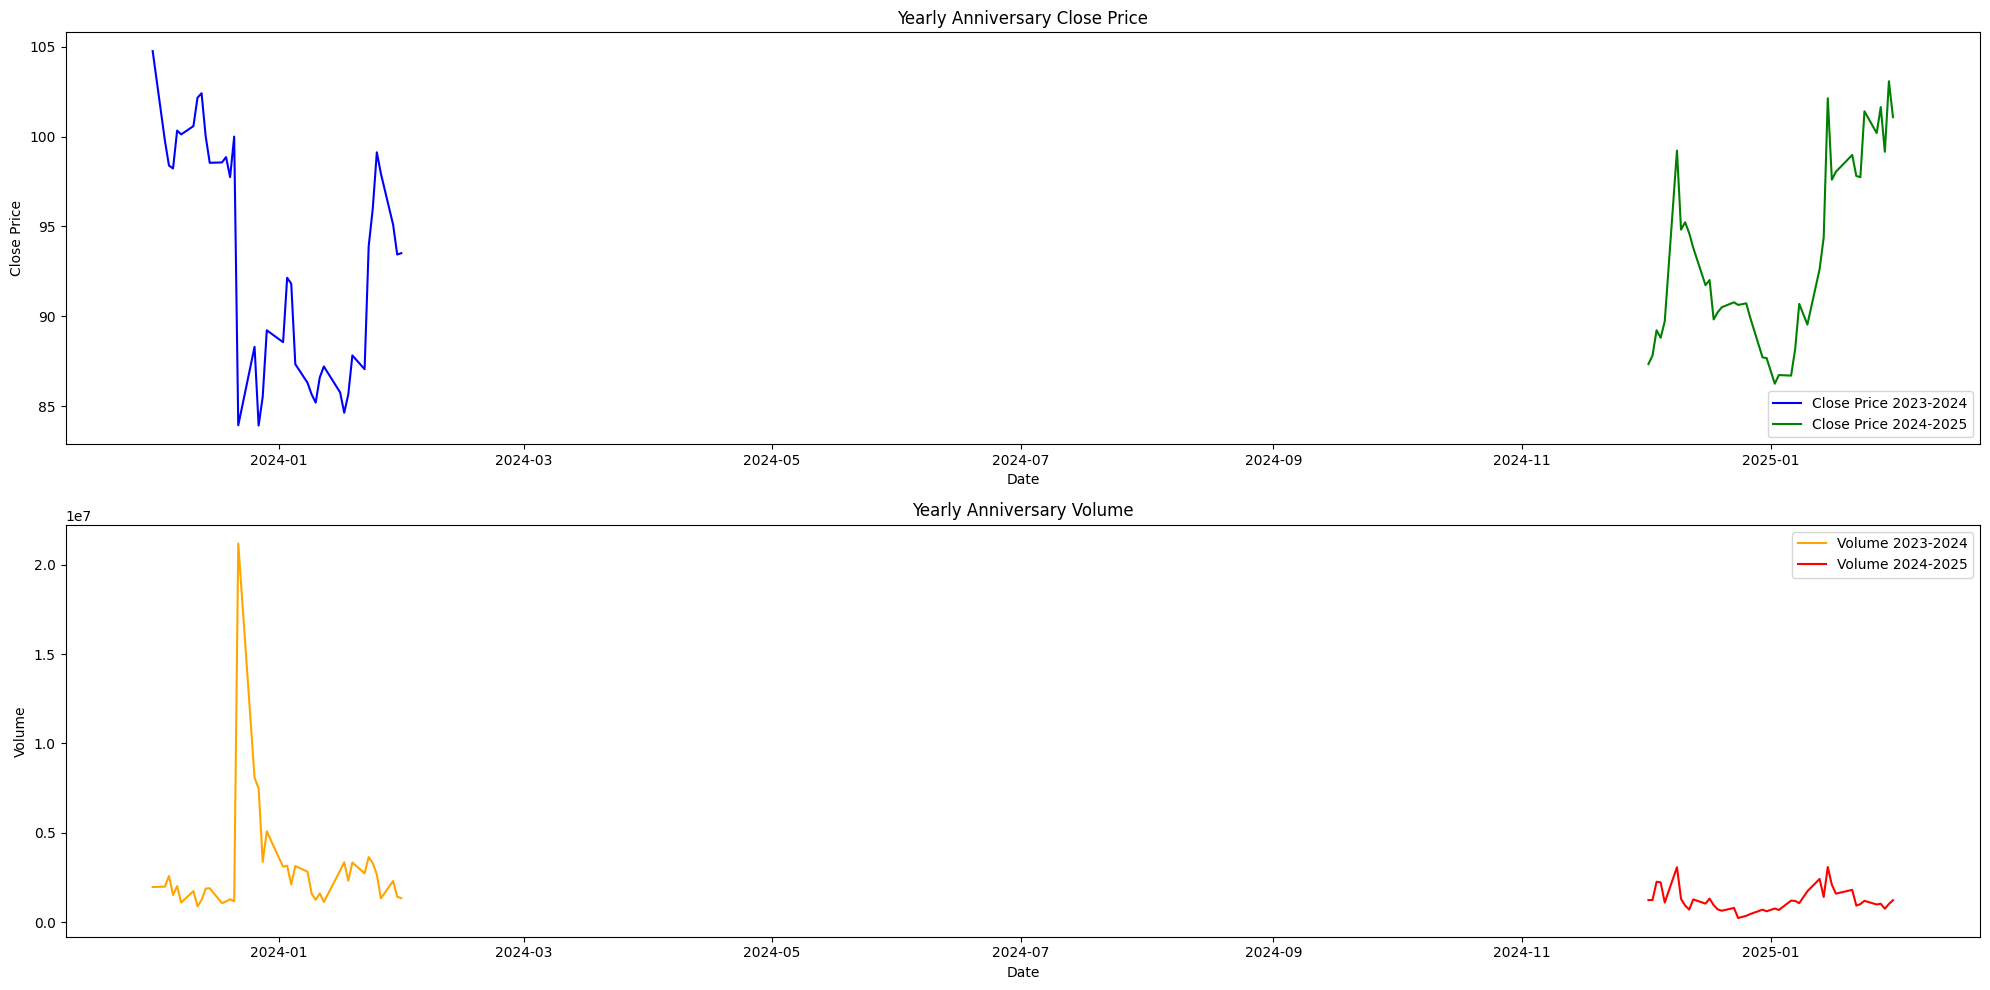

In [139]:
Yearly_anniversary = TradeHistory[TradeHistory.index.month.isin([12, 1])]
Yearly_anniversary_2023 = Yearly_anniversary[Yearly_anniversary.index < '2024-06-06']
Yearly_anniversary_2024 = Yearly_anniversary[Yearly_anniversary.index > '2024-06-06']
anni = [Yearly_anniversary_2023, Yearly_anniversary_2024]

#plot 2 most valuable columns, Close and Volume
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
sns.lineplot(data=Yearly_anniversary_2023, x=Yearly_anniversary_2023.index, y='Close', label='Close Price 2023-2024', color='blue')
sns.lineplot(data=Yearly_anniversary_2024, x=Yearly_anniversary_2024.index, y='Close', label='Close Price 2024-2025', color='green')
plt.title('Yearly Anniversary Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

plt.subplot(2, 1, 2)
sns.lineplot(data=Yearly_anniversary_2023, x=Yearly_anniversary_2023.index, y='Volume', label='Volume 2023-2024', color='orange')
sns.lineplot(data=Yearly_anniversary_2024, x=Yearly_anniversary_2024.index, y='Volume', label='Volume 2024-2025', color='red')
plt.title('Yearly Anniversary Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()

plt.tight_layout()
plt.show()

Chúng ta có thể thấy một quy luật ở đây.

Về giá đóng phiên, giá có xu hướng giảm vào tháng 12 và tăng trở lại vào tháng 1 năm sau.

Tuy nhiên, sự sụt giảm này vẫn có vẻ bất thường. Nhưng nhờ vào tìm kiếm, chúng ta đã biết lý do cho sự sụt giảm nhanh chóng đó, [chính sách dự thảo mới từ Trung Quốc nhằm hạn chế chi tiêu quá mức vào trò chơi trực tuyến vào đầu năm 2024](https://global.chinadaily.com.cn/a/202312/23/WS658616e8a31040ac301a927d.html#:~:text=Shares%20of%20major%20Chinese%20online%20gaming%20companies%20including,aimed%20at%20curbing%20excessive%20spending%20on%20online%20gaming.). Tin tức này không có trên Finnviz. Giờ đây, chúng ta có thể xác nhận ảnh hưởng của các sự kiện cuối năm đến giá cổ phiếu.

Bây giờ chúng ta sẽ xem cổ tức ảnh hưởng đến giá cổ phiếu như thế nào.

Bằng cách tìm kiếm, chúng ta có thể thu thập được một số thông tin về ngày giao dịch không hưởng quyền, diễn ra vào khoảng ngày 5-6/03/2024.

Bây giờ chúng ta sẽ xem điều đó đó ảnh hưởng đến giá cổ phiếu như thế nào.

                           Dividends  Stock Splits
Date                                              
2024-03-01 00:00:00-05:00       0.00           0.0
2024-03-04 00:00:00-05:00       0.00           0.0
2024-03-05 00:00:00-05:00       0.00           0.0
2024-03-06 00:00:00-05:00       0.00           0.0
2024-03-07 00:00:00-05:00       0.00           0.0
2024-03-08 00:00:00-05:00       0.00           0.0
2024-03-11 00:00:00-04:00       0.00           0.0
2024-03-12 00:00:00-04:00       0.00           0.0
2024-03-13 00:00:00-04:00       1.08           0.0
2024-03-14 00:00:00-04:00       0.00           0.0
2024-03-15 00:00:00-04:00       0.00           0.0
2024-03-18 00:00:00-04:00       0.00           0.0
2024-03-19 00:00:00-04:00       0.00           0.0
2024-03-20 00:00:00-04:00       0.00           0.0
2024-03-21 00:00:00-04:00       0.00           0.0
2024-03-22 00:00:00-04:00       0.00           0.0
2024-03-25 00:00:00-04:00       0.00           0.0
2024-03-26 00:00:00-04:00      

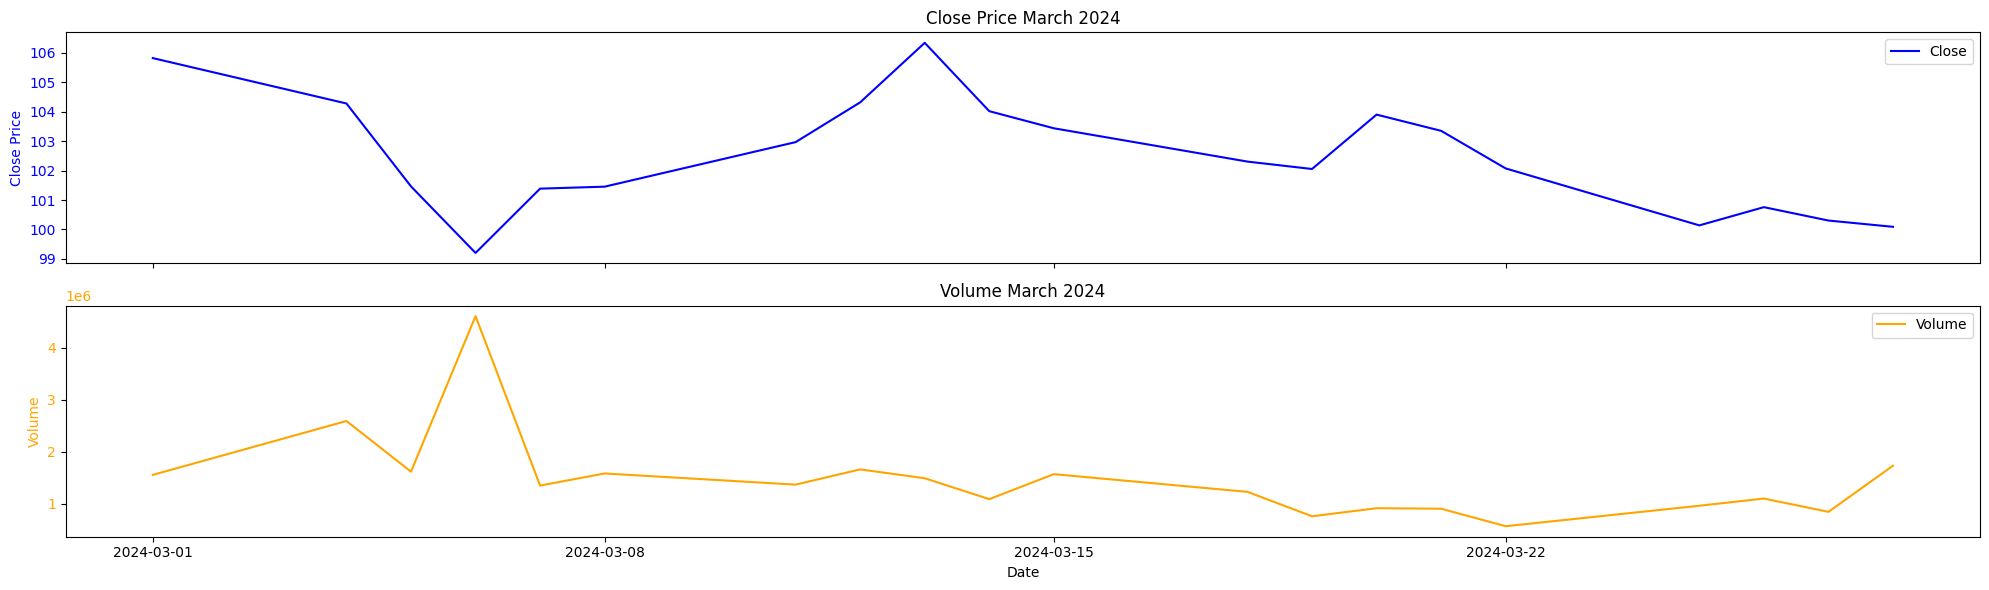

In [140]:
march_2024 = TradeHistory[(TradeHistory.index >= '2024-03-01') & (TradeHistory.index <= '2024-03-31')]
print(march_2024[['Dividends', 'Stock Splits']])

fig, axs = plt.subplots(2, 1, figsize=(20, 6), sharex=True)

sns.lineplot(data=march_2024, x=march_2024.index, y='Close', label='Close', color='blue', ax=axs[0])
axs[0].set_ylabel('Close Price', color='blue')
axs[0].tick_params(axis='y', labelcolor='blue')
axs[0].set_xlabel('Date')
axs[0].set_title('Close Price March 2024')
axs[0].set_xticks(march_2024.index[::5])

sns.lineplot(data=march_2024, x=march_2024.index, y='Volume', label='Volume', color='orange', ax=axs[1])
axs[1].set_ylabel('Volume', color='orange')
axs[1].tick_params(axis='y', labelcolor='orange')
axs[1].set_xlabel('Date')
axs[1].set_title('Volume March 2024')
axs[1].set_xticks(march_2024.index[::5])

plt.tight_layout()
plt.show()

Vào ngày giao dịch không hưởng quyền, giá cổ phiếu sẽ được điều chỉnh giảm một lượng tương đương với giá trị cổ tức. Cổ tức quý 4 năm 2023 là 0,24405 USD mỗi cổ phiếu (1,22025 USD mỗi ADS). Điều này cho thấy sự sụt giảm so với giá cổ phiếu khoảng 105 USD. Điều này có thể được chứng minh bằng thông tin về Cổ tức vào ngày 13/03/2024. Để biết thêm thông tin về ngày giao dịch không hưởng quyền, vui lòng nhấp vào [đây](https://www.trading212.com/learn/dividends/ex-dividend).

Bây giờ chúng ta đã biết cách cổ tức và ngày lễ hàng năm ảnh hưởng đến giá cổ phiếu.

# Tính độ biến động (volatility) theo tháng hoặc quý.

Công thức tính Volatility quý:

$$ \text{Volatility}_{\text{quý}} = \sigma_{\text{ngày}} \times \sqrt{N_{\text{quý}}} $$

Trong đó:
* $ \text{Volatility}_{\text{quý}} $: Độ biến động theo quý.
* $ \sigma_{\text{ngày}} $: Độ lệch chuẩn (Standard Deviation) của lợi suất hàng ngày (độ biến động hàng ngày).
* $ N_{\text{quý}} $: Số ngày giao dịch trong một quý (ví dụ: 63).

Dựa vào những quan sát trên, chúng ta nên tính toán Biến động theo Quý (vì ảnh hưởng của bất kỳ tin tức nào cũng kéo dài, có thể lên đến 2 tháng).

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12180\1588202607.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  quarterly_v['Quarter'] = quarterly_v.index.to_period('Q')


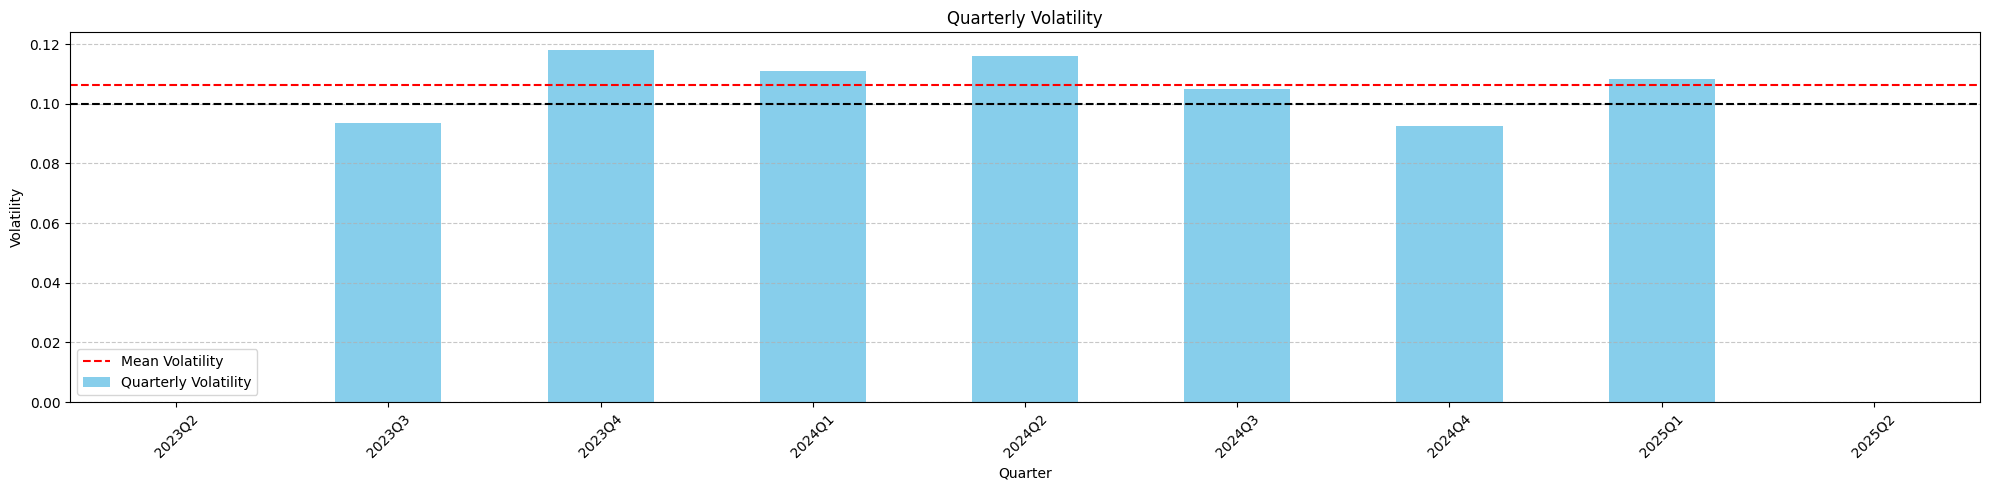

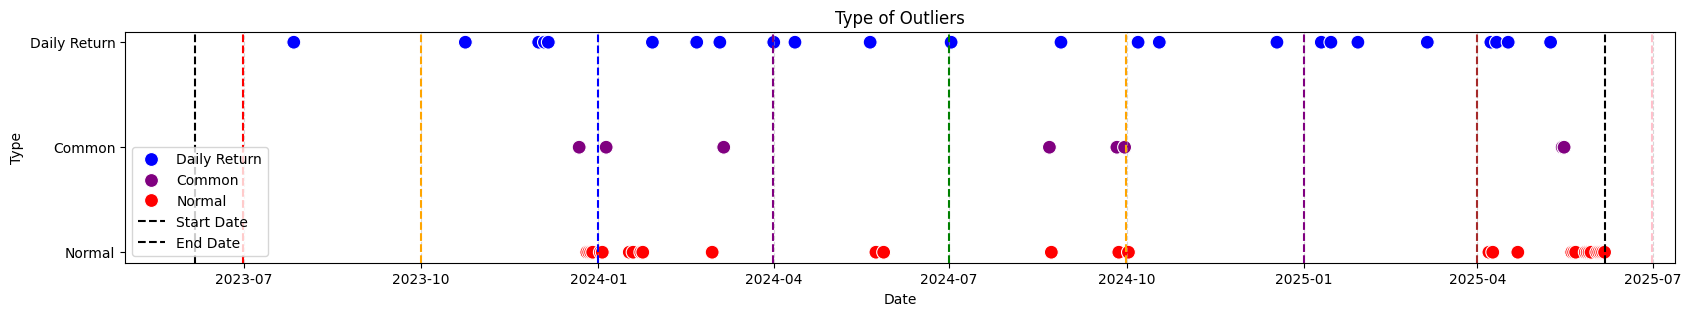

In [141]:
quarterly_v = TradeHistory.copy()
quarterly_v['Quarter'] = quarterly_v.index.to_period('Q')

quarterly_volatility = (quarterly_v.groupby('Quarter').agg(std_daily_return=('Daily return', 'std'), trade_days=('Daily return', 'count')))
quarterly_volatility['Quarterly Volatility'] = quarterly_volatility['std_daily_return']*(quarterly_volatility['trade_days'])**0.5
quarterly_volatility['Quarterly Volatility'] = quarterly_volatility['Quarterly Volatility'].iloc[1:-1] #skip the first and last quarter as they are not complete

# quarterly_volatility[['Quarterly Volatility']]
# plot Quarterly Volatility
plt.figure(figsize=(20, 5))
quarterly_volatility['Quarterly Volatility'].plot(kind='bar', color='skyblue')
plt.title('Quarterly Volatility')
plt.xlabel('Quarter')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.axhline(y=0.1, color='black', linestyle='--')
plt.axhline(y=quarterly_volatility['Quarterly Volatility'].mean(), color='red', linestyle='--', label='Mean Volatility')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('quarterly_volatility.png')
plt.show()

plt.figure(figsize=(20, 3))
sns.scatterplot(data=outliers_type_df, x=outliers_type_df.index, y='Type', hue='Type',palette={'Normal': 'red', 'Daily Return': 'blue', 'Common': 'purple'}, markers='o', s=100)
plt.title("Type of Outliers")
plt.xlabel("Date")
plt.ylabel("Type")
plt.axvline(x=TradeHistory.index[0], color='black', linestyle='--', label='Start Date')
plt.axvline(x=TradeHistory.index[-1], color='black', linestyle='--', label='End Date')
plt.axvline(x=pd.to_datetime('2023-07-01'), color='red', linestyle='--')
plt.axvline(x=pd.to_datetime('2023-10-01'), color='orange', linestyle='--')
plt.axvline(x=pd.to_datetime('2024-01-01'), color='blue', linestyle='--')
plt.axvline(x=pd.to_datetime('2024-04-01'), color='purple', linestyle='--')
plt.axvline(x=pd.to_datetime('2024-07-01'), color='green', linestyle='--')
plt.axvline(x=pd.to_datetime('2024-10-01'), color='orange', linestyle='--')
plt.axvline(x=pd.to_datetime('2025-01-01'), color='purple', linestyle='--')
plt.axvline(x=pd.to_datetime('2025-04-01'), color='brown', linestyle='--')
plt.axvline(x=pd.to_datetime('2025-07-01'), color='pink', linestyle='--')
plt.legend(loc='lower left')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# **Biến Động Quý Của Cổ Phiếu**
Nhìn vào Bảng trên, chúng ta thấy Biến động Quý của cổ phiếu này đã dao động đáng kể theo thời gian:

- Từ Quý 3/2023 đến Quý 4/2023, biến động có xu hướng tăng đáng kể, từ 0.0936 lên 0.1180. Sự tăng cho thấy cổ phiếu trở nên kém ổn định hơn trong giai đoạn này.

- Từ Quý 1/2024 đến Quý 3/2024, biến động vẫn duy trì ở mức cao (> 0.1), mặc dù có một số thay đổi nhỏ.

- Từ Quý 4/2024 đến nay, biến động đã giảm nhẹ nhưng sau đó đã lấy lại giá trị trước đó.

- Hơn một nửa giá trị Biến động Quý nằm trên Đường trung bình, cho thấy biến động của cổ phiếu này có xu hướng biến động cao hơn mức trung bình.

Với giá trị Biến động Quý từ 9% đến gần 12%, so với một cổ phiếu ổn định như Coca-Cola với biến động chỉ từ 5% đến 7%, và kết hợp với Phân phối lợi nhuận hàng ngày, chúng ta có thể khẳng định chắc chắn rằng cổ phiếu này không ổn định.

Kết hợp với biểu đồ các giá trị Outliers, chúng ta có thể thấy rằng các giá trị Outliers cơ bản thường xuất hiện có liên quan với Outliers của Lãi ngày.

Để hiểu rõ hơn, chúng ta sẽ kiểm tra sâu hơn giai đoạn từ Quý 3/2024 đến Quý 1/2025 để xem sự kiện cụ thể nào đã tạo ra những thay đổi này.

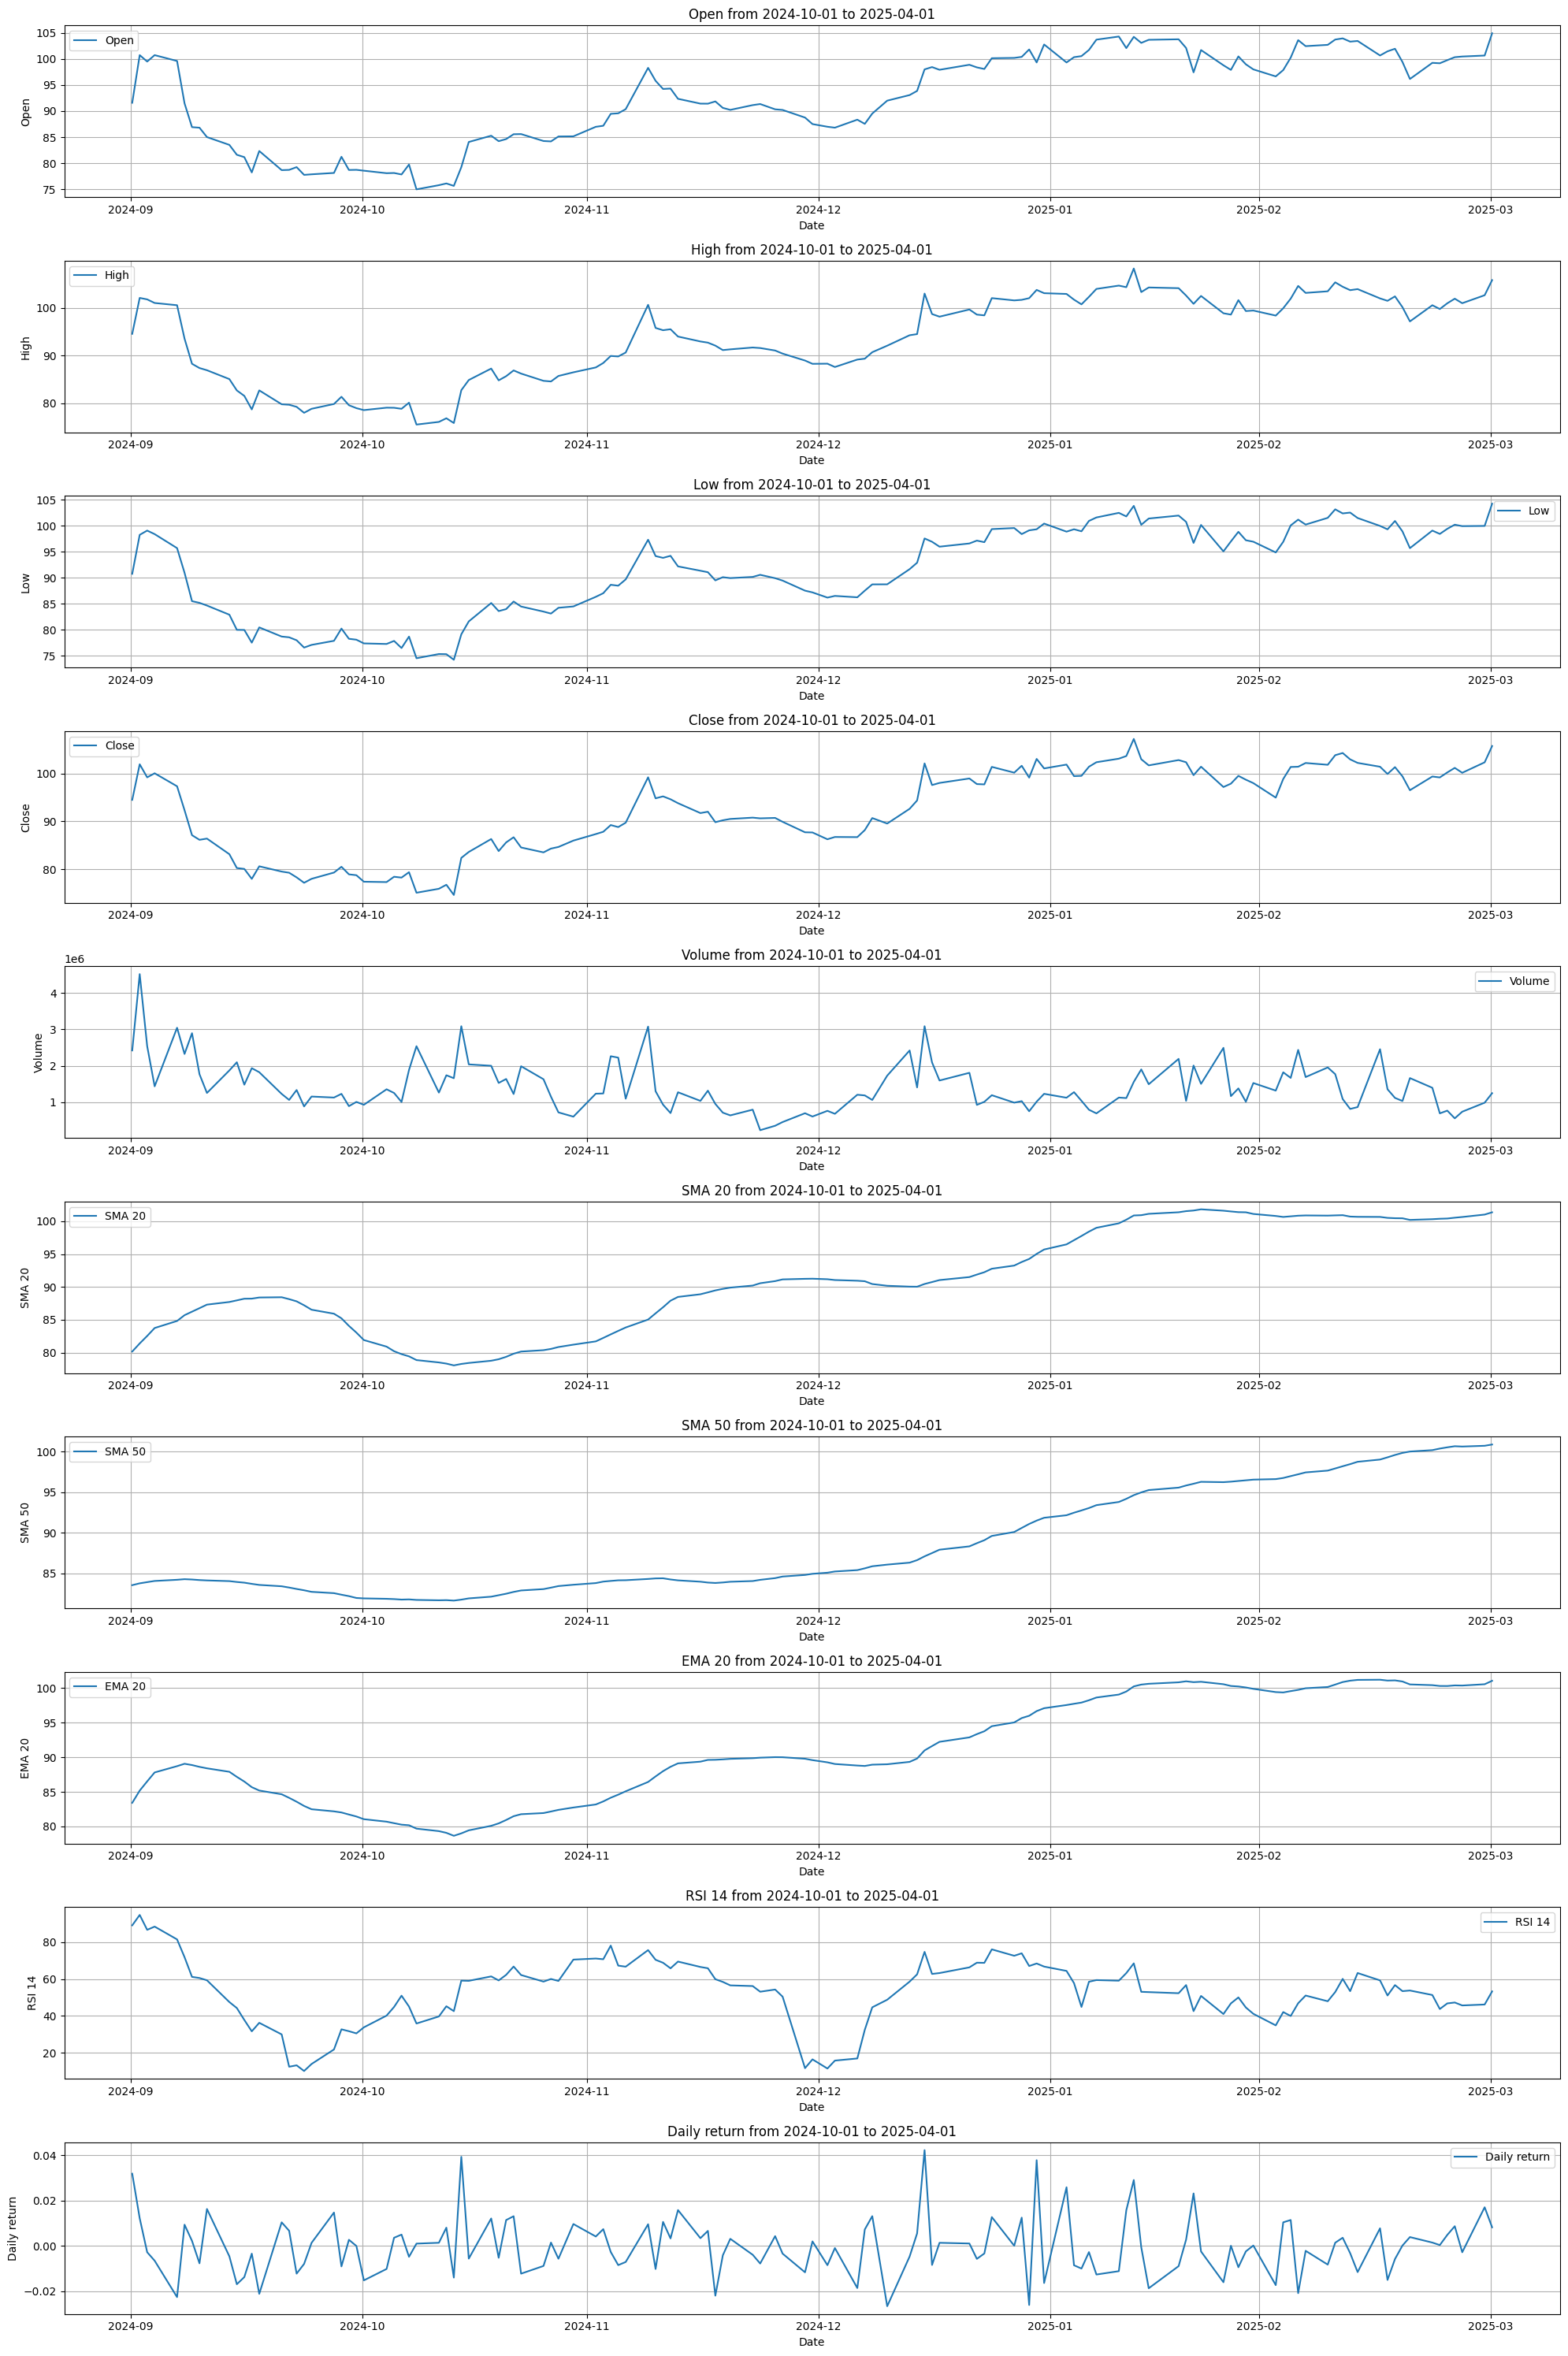

                    category  \
datetime                       
2024-10-02 00:35:38  company   
2024-10-02 10:07:00  company   
2024-10-02 11:05:00  company   
2024-10-03 05:30:22  company   
2024-10-03 12:04:00  company   
...                      ...   
2025-03-07 16:48:07  company   
2025-03-20 00:35:00  company   
2025-03-20 16:35:54  company   
2025-03-25 13:07:05  company   
2025-03-30 20:34:52  company   

                                                              headline  \
datetime                                                                 
2024-10-02 00:35:38  NetEase, Inc. (NTES): Among the Best Bargain S...   
2024-10-02 10:07:00  Here is how many Chinese ADRs are performing f...   
2024-10-02 11:05:00   NetEase Inc (NTES) Trading 4.88% Higher on Oct 2   
2024-10-03 05:30:22  Top 50 High Quality Dividend Stocks - Septembe...   
2024-10-03 12:04:00  DRAG, a newly launched ETF that provides expos...   
...                                                              

In [142]:
start_date = '2024-10-01'
end_date = '2025-04-01'
df_check = TradeHistory[(TradeHistory.index >= start_date) & (TradeHistory.index <= end_date)].copy()
finnhub_client = finnhub.Client(api_key=FINNHUB_API_KEY)
news_items = finnhub_client.company_news(symbol, _from=start_date, to=end_date)

news_data = []
if news_items:
    for item in news_items:
        news_data.append({
            'datetime': pd.to_datetime(item.get('datetime'), unit='s'),
            'category': item.get('category'),
            'headline': item.get('headline'),
            'id': item.get('id'),
            'image': item.get('image'),
            'related': item.get('related'),
            'source': item.get('source'),
            'summary': item.get('summary'),
            'url': item.get('url')
        })
    news_df = pd.DataFrame(news_data).drop_duplicates(subset=['id']).set_index('datetime').sort_index()
else:
    news_df = pd.DataFrame()
    
    
#save the news data to a CSV file
csv_file_name = f"{symbol}_news_data_{start_date}_to_{end_date}.csv"
news_df.to_csv(csv_file_name)

col_to_plot = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA 20', 'SMA 50', 'EMA 20', 'RSI 14', 'Daily return']
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(20, 30), sharex=False)    
for col in col_to_plot:
    ax = axes[col_to_plot.index(col)]
    sns.lineplot(data=df_check, x=df_check.index, y=col, ax=ax, label=col)
    ax.set_title(f"{col} from {start_date} to {end_date}")
    ax.set_ylabel(col)
    ax.set_xlabel('Date')
    ax.legend()
    ax.grid(True)
    ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
plt.tight_layout()
plt.show()

print(news_df)

Nhìn vào biểu đồ trên, chúng ta có thể nhận thấy một số thông tin:

Đầu tiên, chúng ta thấy một điểm thấp trên biểu đồ RSI 14 và Volume vào khoảng 12/2024.

Thứ hai, tất cả các biểu đồ khác, ngoại trừ Daily return, đều có xu hướng tăng chậm.

Chúng ta sẽ tìm kiếm tin tức xung quanh tháng 12 năm 2024 để tìm lý do cho điểm thấp trong RSI 14 và Volume này.

In [143]:
news_2024_12 = news_df[(news_df.index >= '2024-11-15') & (news_df.index <= '2024-12-15')]
reason1 = news_2024_12.iloc[1]
reason2 = news_2024_12.iloc[6]
print(reason1, reason2)

category                                              company
headline    NetEase, Inc. (NASDAQ:NTES) Misses on Earnings...
id                                                  131396037
image       https://s.yimg.com/ny/api/res/1.2/h47e0lHvKCq0...
related                                                  NTES
source                                                  Yahoo
summary     We recently published a list of 12 Cheap Chine...
url         https://finnhub.io/api/news?id=6d2f9c428ca5eb9...
Name: 2024-11-16 15:33:16, dtype: object category                                              company
headline    NetEase cuts jobs in Shenzhen as first-person ...
id                                                  131709430
image       https://s.yimg.com/ny/api/res/1.2/ovWnmdQpPZQt...
related                                                  NTES
source                                                  Yahoo
summary     NetEase, China's second-largest video gaming c...
url         https://finnhub.i

Chúng ta có thể thấy lý do cho sự sụt giảm nói trên từ những tin tức trên:

- Làn sóng sa thải (lý do 2)

- Doanh thu quý 3/2024 không đạt kỳ vọng (lý do 1)

Những tin tức này đã khiến các nhà đầu tư mất niềm tin. Bên cạnh đó, khi kết hợp với tâm lý cuối năm, lúc mà mọi người thường ngại đầu tư và trực tiếp giảm Volume giao dịch, ta thấy được lý do cho sự sụt giảm của Volume và RSI 14, phù hợp với 1 khoảng lõm trong đồ thị Close vào khoảng 12/2024.

# Phân tích tương quan giữa giá đóng cửa và các chỉ số SMA, RSI.

New value: Correlation Coefficient

Công thức hệ số tương quan Pearson giữa hai biến X và Y:

$$
r_{XY} = \frac{\sum_{i=1}^n (X_i - \overline{X})(Y_i - \overline{Y})}{\sqrt{\sum_{i=1}^n (X_i - \overline{X})^2} \sqrt{\sum_{i=1}^n (Y_i - \overline{Y})^2}}
$$

Trong đó:
- $X_i$, $Y_i$: giá trị của biến X, Y tại quan sát thứ i
- $\overline{X}$, $\overline{Y}$: giá trị trung bình của X, Y
- $n$: số lượng quan sát

Hệ số này nằm trong khoảng từ -1 đến 1, cho biết mức độ và chiều hướng tương quan tuyến tính giữa hai biến.


0.7014074196708807 0.8626105722610896 0.47007966423842695


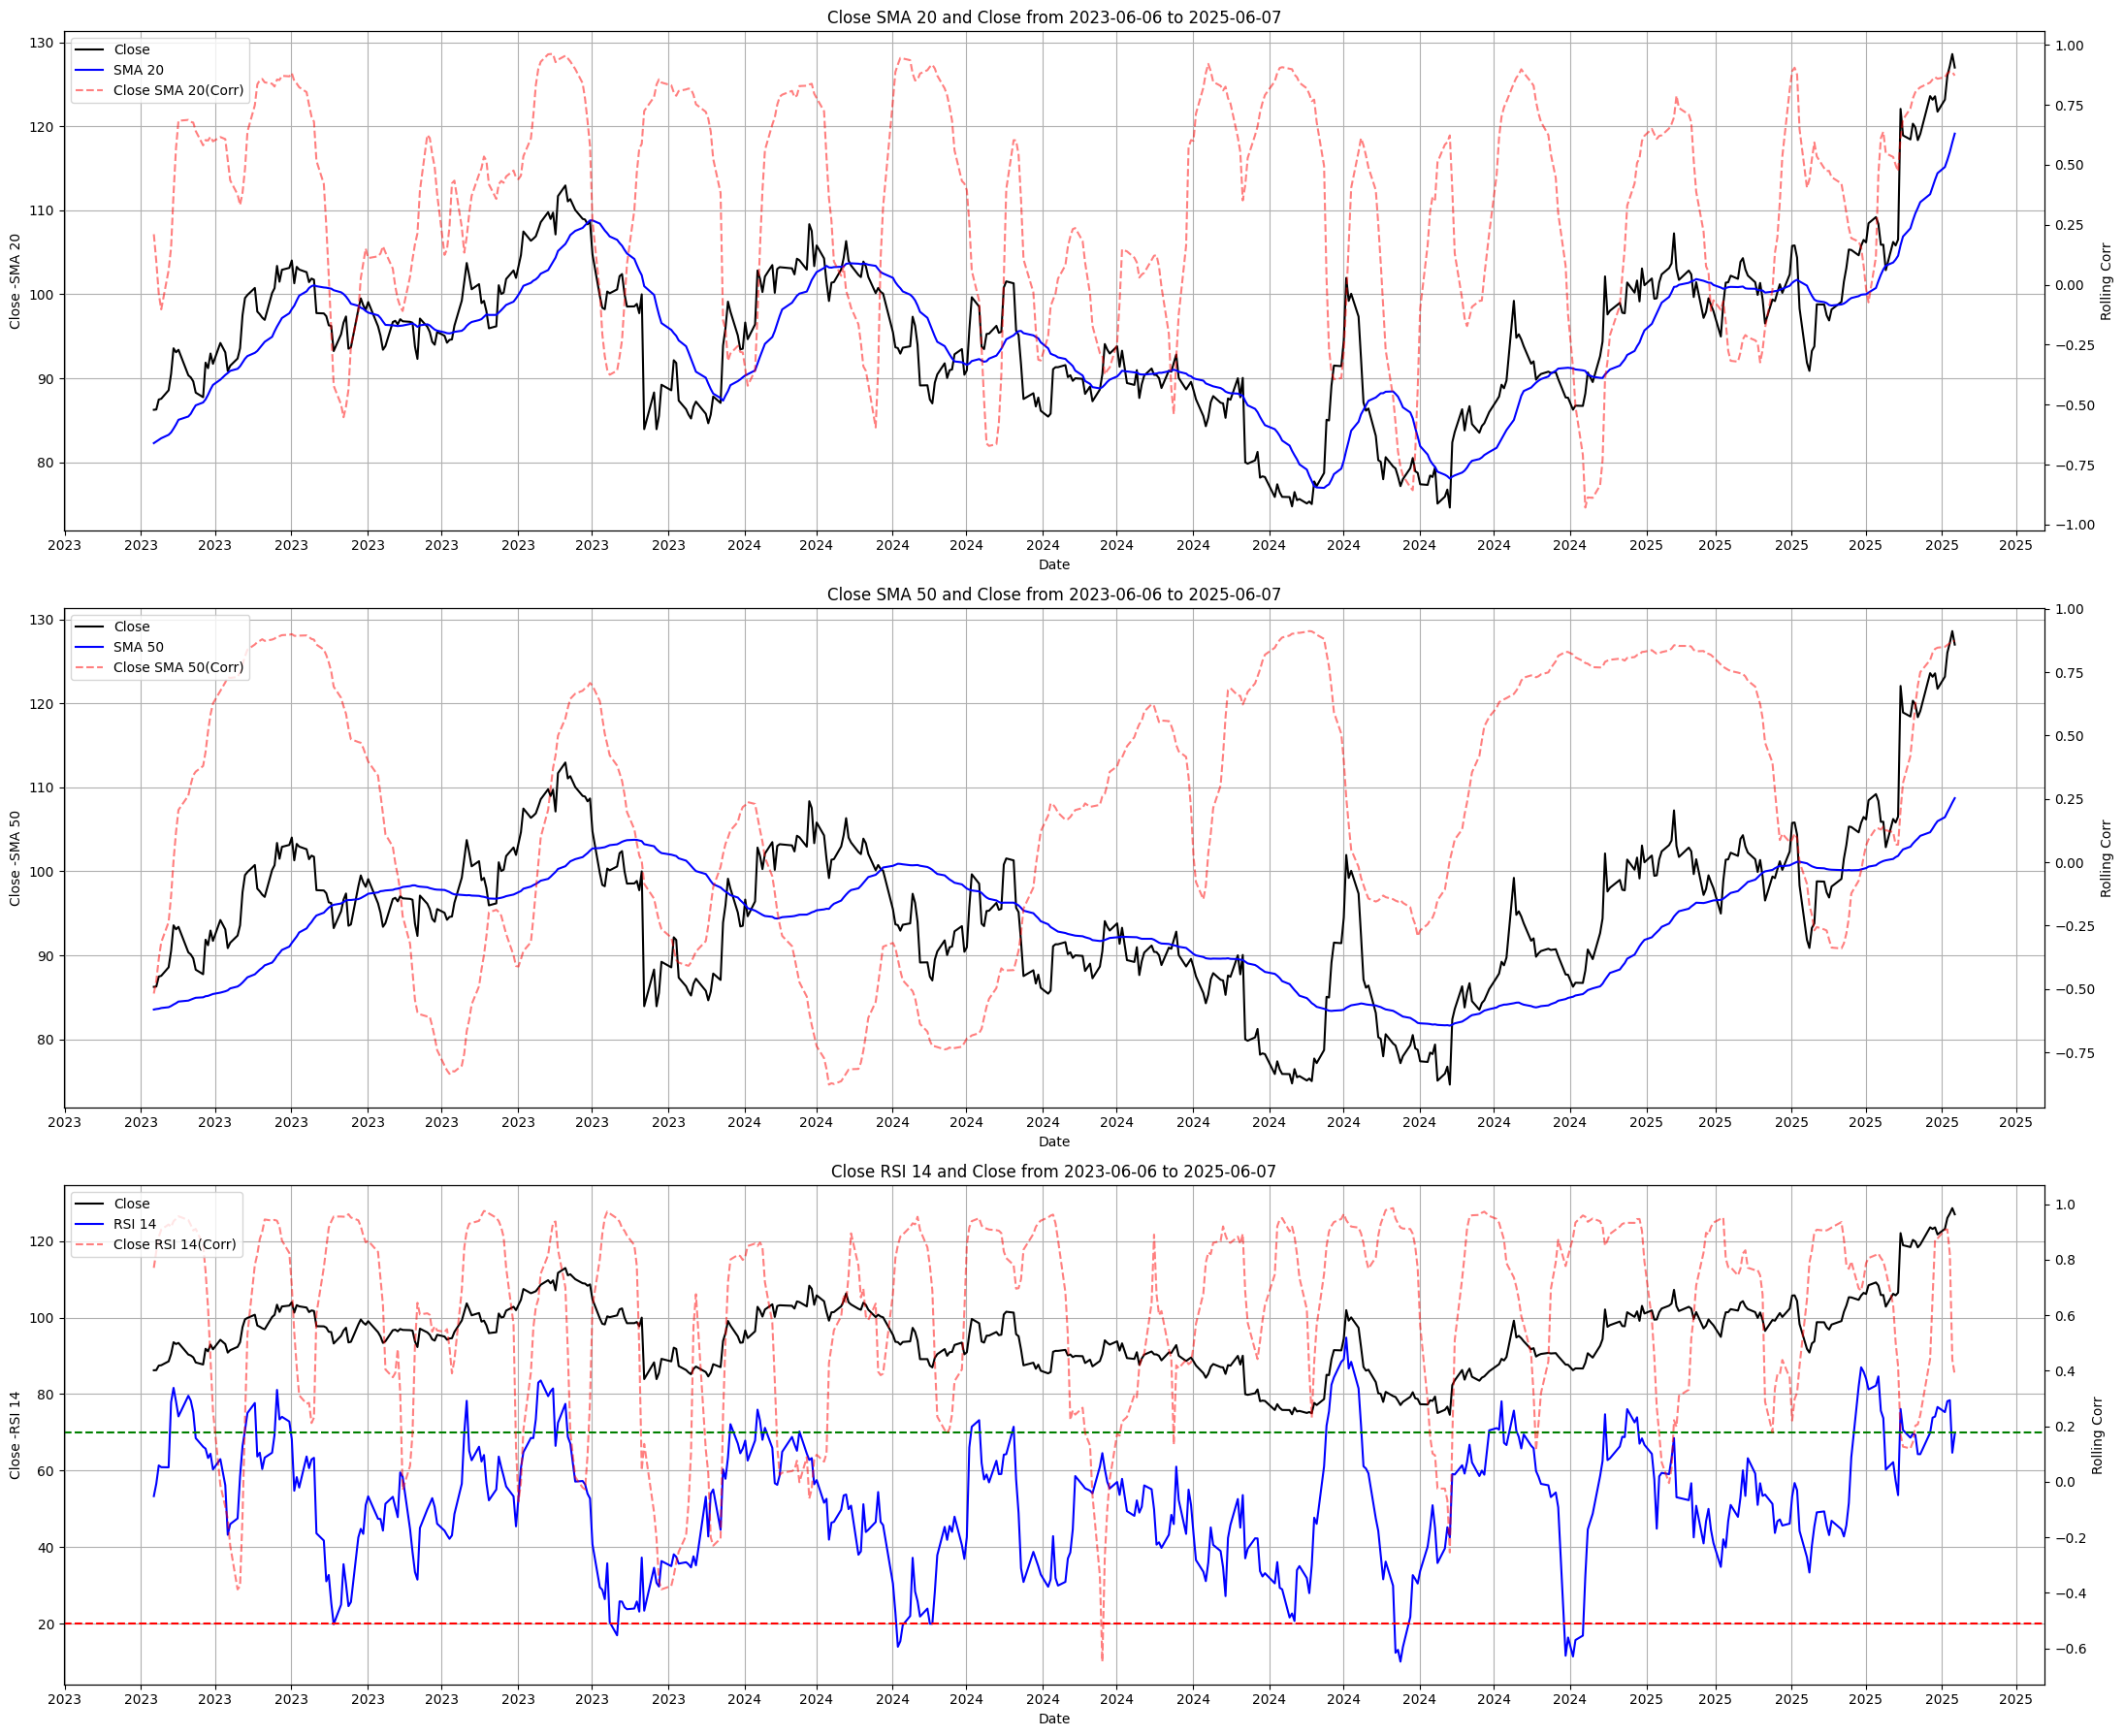

In [144]:
temp = NTES_stockData.history(start='2023-01-11', end='2023-06-06') #we need 100 days before 2023-06-06 to calculate SMA and RSI, specifically SMA 50
TradeHistory = pd.concat([temp, TradeHistory]).sort_index()

#recalculate all the needed values
TradeHistory['SMA 20'] = TradeHistory['Close'].rolling(window=20).mean() # SMA 20
TradeHistory['SMA 50'] = TradeHistory['Close'].rolling(window=50).mean() #SMA 50
TradeHistory['EMA 20'] = TradeHistory['Close'].ewm(span=20, adjust=False).mean() #EMA 20
delta = TradeHistory['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14, min_periods=14).mean()
avg_loss = loss.rolling(window=14, min_periods=14).mean()
rs = avg_gain/avg_loss
rsi = 100 - (100 / (1 + rs))
TradeHistory['RSI 14'] = rsi # RSI-14

Close_SMA50_overview = TradeHistory['Close'].corr(TradeHistory['SMA 50'])
Close_SMA20_overview = TradeHistory['Close'].corr(TradeHistory['SMA 20'])
Close_RSI14_overview = TradeHistory['Close'].corr(TradeHistory['RSI 14'])
TradeHistory['Close SMA 20'] = TradeHistory['Close'].rolling(window=20).corr(TradeHistory['SMA 20'])
TradeHistory['Close SMA 50'] = TradeHistory['Close'].rolling(window=50).corr(TradeHistory['SMA 50'])
TradeHistory['Close RSI 14'] = TradeHistory['Close'].rolling(window=14).corr(TradeHistory['RSI 14'])
print(Close_SMA50_overview, Close_SMA20_overview, Close_RSI14_overview)

TradeHistory = TradeHistory.iloc[100:].copy()

#plot the correlation
col_to_plot = ['Close SMA 20', 'Close SMA 50', 'Close RSI 14']
fig, axes = plt.subplots(3, 1, figsize=(22, 18))
for col in col_to_plot:
    ax = axes[col_to_plot.index(col)]
    ax.plot(TradeHistory.index, TradeHistory['Close'], label='Close', color='black')
    ax.plot(TradeHistory.index, TradeHistory[col[6:]], label=col[6:], color='blue')
    ax.set_ylabel('Close -' + col[6:])
    ax.set_xlabel('Date')
    ax.set_title(f"{col} and Close from 2023-06-06 to 2025-06-07")
    ax.grid(True)
    ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
    ax2 = ax.twinx()
    ax2.plot(TradeHistory.index, TradeHistory[col], label=col + '(Corr)', color='red', linestyle='--', alpha=0.5)
    ax2.set_ylabel('Rolling Corr')
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    if col == 'Close RSI 14':
        ax.axhline(y=70, color='green', linestyle='--', label='Oversold')
        ax.axhline(y=20, color='red', linestyle='--', label='Overbought')

plt.tight_layout()
plt.show()

# Dựa vào biểu đồ trên, chúng ta có một số thông tin sau:

Phân tích tương quan khi có điểm cắt

- Đầu tiên, khi đường giá Close cắt đường SMA 20/ SMA 50, mối tương quan giữa các giá trị này sẽ thay đổi ít hoặc nhiều. Giá trị tương quan sẽ tăng, đi ngang hoặc giảm, tùy thuộc vào trạng thái trước đó.

Chẳng hạn, khi giá trị tương quan giữa Close và SMA 50 đang tăng và có một điểm cắt giữa hai giá trị này, tương quan sẽ tăng chậm lại, đi theo đường thẳng hoặc thậm chí giảm xuống. Điều ngược lại cũng đúng.

- So sánh SMA 20 và SMA 50

Thứ hai, chúng ta có thể thấy đường SMA 50 luôn mượt hơn SMA 20. Điều này là do SMA 20 bị ảnh hưởng bởi giá đóng cửa gần đây nhiều hơn SMA 50. Tương tự, điều này cũng xảy ra với mối tương quan giữa Close và hai giá trị này.

Từ đây, chúng ta biết rằng SMA 50 tập trung vào hiệu ứng dài hạn, trong khi SMA 20 tập trung vào hiệu ứng ngắn hạn.

- Ảnh hưởng của RSI 14

Thứ ba, RSI 14 sẽ cường điệu hóa sự biến động giá trị Close, đôi khi theo hướng ngược lại. Điều này cũng đúng với mối tương quan giữa RSI 14 và giá trị Close. Điểm này khác với SMA 20/50 và mối tương quan của chúng với Close, vốn luôn làm mềm sự thay đổi.

Chúng ta có thể thấy điều này bằng cách nhìn vào đường tương quan. Đường tương quan của RSI 14 có biến động nhanh hơn và duy trì gần mức -1/1 hơn so với hai đường tương quan còn lại.

- Xác nhận tính "không ổn định" của cổ phiếu NTES

Cuối cùng, biểu đồ trên xác nhận sự "không ổn định" của cổ phiếu NTES.

**Kết luận**

Với những thông tin thu được, chúng ta có thể kết luận những điều sau:

Mối tương quan giữa giá đóng cửa (Close) và SMA 20, SMA 50, RSI 14 không tuyến tính.

Có sự khác biệt giữa SMA 20 và SMA 50 trong việc phản ứng với sự thay đổi giá.

RSI 14 dễ bị ảnh hưởng bởi biến động giá.

# Biểu đồ giá đóng cửa kèm SMA, EMA.

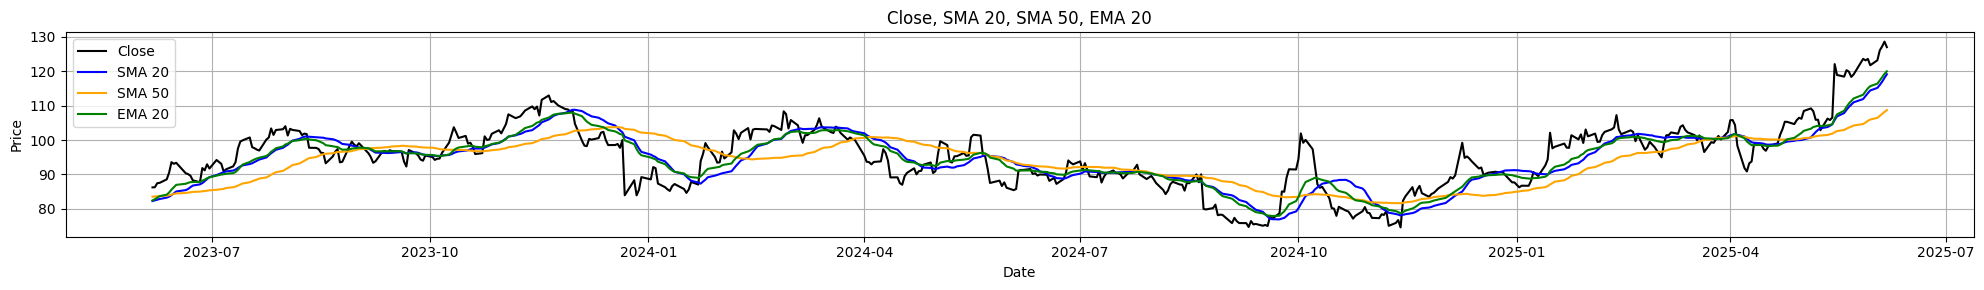

In [145]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=TradeHistory, x=TradeHistory.index, y='Close', label='Close', color='black')
sns.lineplot(data=TradeHistory, x=TradeHistory.index, y='SMA 20', label='SMA 20', color='blue')
sns.lineplot(data=TradeHistory, x=TradeHistory.index, y='SMA 50', label='SMA 50', color='orange')
sns.lineplot(data=TradeHistory, x=TradeHistory.index, y='EMA 20', label='EMA 20', color='green')
plt.title("Close, SMA 20, SMA 50, EMA 20")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Heatmap ma trận tương quan giữa các biến.

Heatmap giữa Close, RSI, EMA, SMA

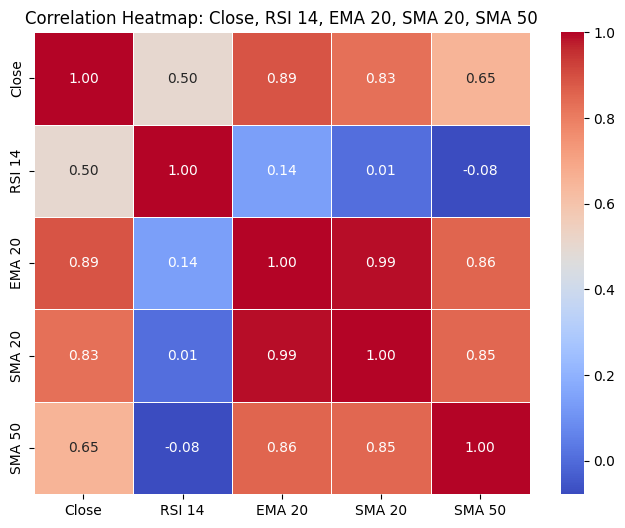

In [146]:
heatmap_col = ['Close', 'RSI 14', 'EMA 20', 'SMA 20', 'SMA 50']
corr_matrix = TradeHistory[heatmap_col].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap: Close, RSI 14, EMA 20, SMA 20, SMA 50')
plt.show()

Dựa vào heatmap ở trên, kết hợp phần Phân tích tương quan giữa giá đóng cửa và các chỉ số SMA, RSI, ta rút ra được các điều sau.

- Đầu tiên, sự khác nhau giữa SMA và RSI như đã nêu ở trên.

- Thứ hai, SMA theo khá sát sự biến động về giá

- Thứ ba, SMA 50 bị ảnh hưởng ít hơn bởi sự điều chỉnh giá ngắn hạn.

Với biểu đồ nhiệt này, chúng ta có được một số thông tin chi tiết về đường trung bình động hàm mũ (EMA) 20:

- EMA 20 minh họa sự thay đổi giá gần đây tốt hơn so với đường SMA, điều này có thể được chứng minh bằng công thức của nó.

- Mặc dù vậy, EMA 20 và SMA 20 thực hiện gần như cùng một công việc, được chứng minh bằng biểu đồ nhiệt với hệ số tương quan 0.99

## Đặc biệt: So sánh cổ phiếu các công ty game có tiếng khác

Các công ty lựa chọn: EA, Capcom, Roblox

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12180\3196732383.py:19: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  quarterly_v['Quarter'] = quarterly_v.index.to_period('Q')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12180\3196732383.py:19: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  quarterly_v['Quarter'] = quarterly_v.index.to_period('Q')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12180\3196732383.py:19: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  quarterly_v['Quarter'] = quarterly_v.index.to_period('Q')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12180\3196732383.py:19: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  quarterly_v['Quarter'] = quarterly_v.index.to_period('Q')


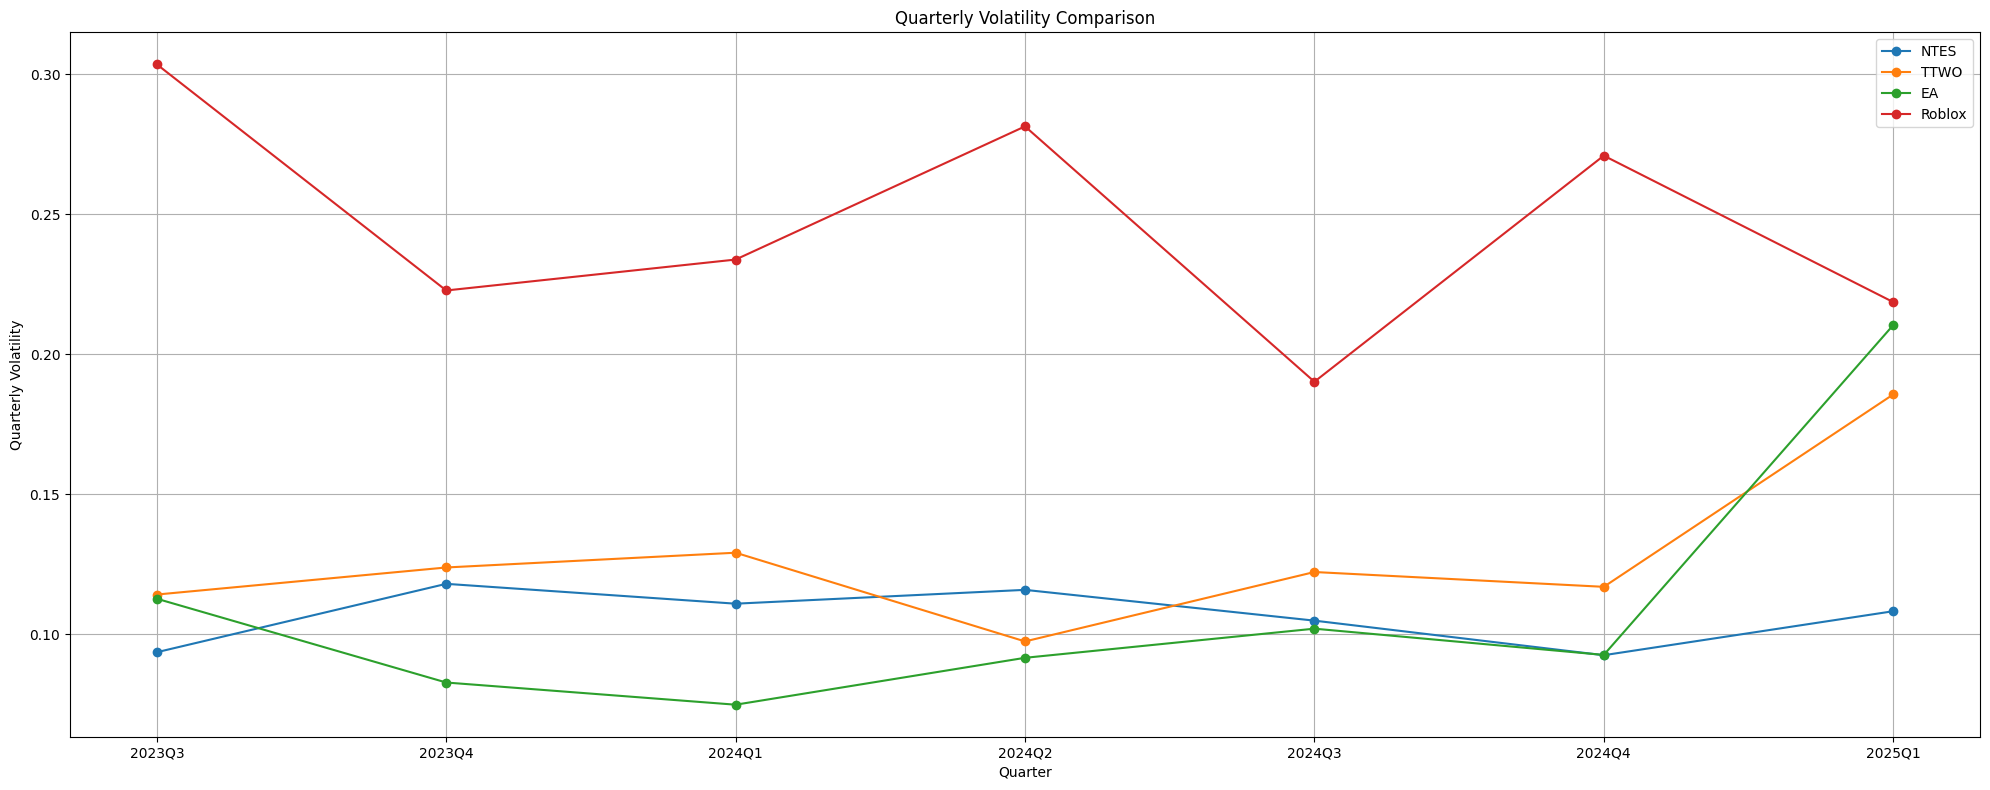

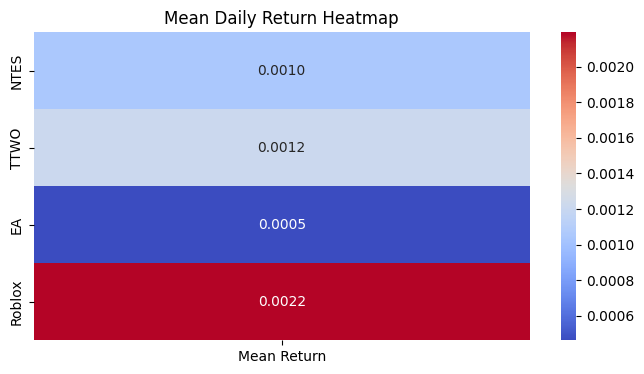

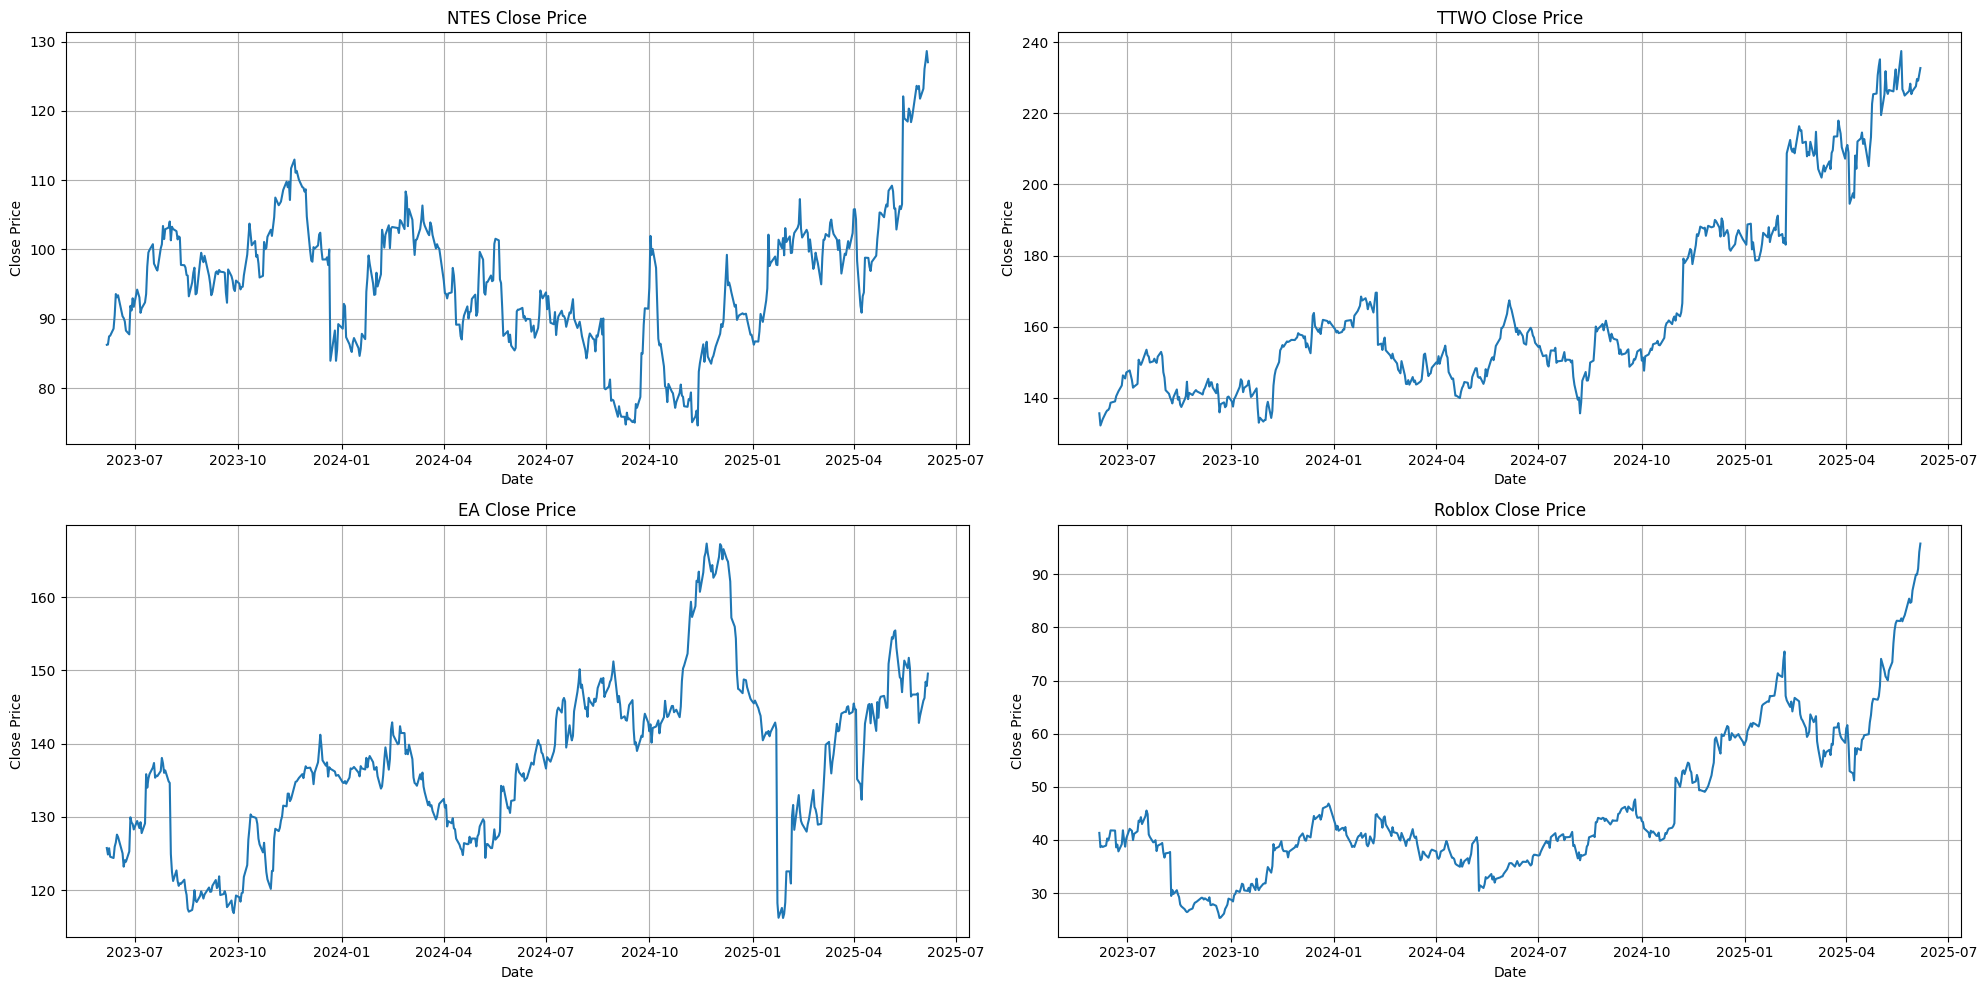

In [147]:
TTWO_stockData = yf.Ticker("TTWO")
TTWO_TradeHistory = TTWO_stockData.history(start="2023-06-06", end="2025-06-07")
TTWO_TradeHistory.index = pd.to_datetime(TTWO_TradeHistory.index)
TTWO_TradeHistory['Daily return'] = TTWO_TradeHistory['Close'].pct_change()

EA_stockData = yf.Ticker("EA")
EA_TradeHistory = EA_stockData.history(start="2023-06-06", end="2025-06-07")
EA_TradeHistory.index = pd.to_datetime(EA_TradeHistory.index)
EA_TradeHistory['Daily return'] = EA_TradeHistory['Close'].pct_change()

Roblox_stockData = yf.Ticker("RBLX")
Roblox_TradeHistory = Roblox_stockData.history(start="2023-06-06", end="2025-06-07")
Roblox_TradeHistory.index = pd.to_datetime(Roblox_TradeHistory.index)
Roblox_TradeHistory['Daily return'] = Roblox_TradeHistory['Close'].pct_change()

#calculate the Volatility for each stock
def calculate_volatility(TradeHistory):
    quarterly_v = TradeHistory.copy()
    quarterly_v['Quarter'] = quarterly_v.index.to_period('Q')

    quarterly_volatility = (quarterly_v.groupby('Quarter').agg(std_daily_return=('Daily return', 'std'), trade_days=('Daily return', 'count')))
    quarterly_volatility['Quarterly Volatility'] = quarterly_volatility['std_daily_return']*(quarterly_volatility['trade_days'])**0.5
    quarterly_volatility['Quarterly Volatility'] = quarterly_volatility['Quarterly Volatility'].iloc[1:-1] #skip the first and last quarter as they are not complete
    
    return quarterly_volatility['Quarterly Volatility']

TTWO_volatility = calculate_volatility(TTWO_TradeHistory)
EA_volatility = calculate_volatility(EA_TradeHistory)
Roblox_volatility = calculate_volatility(Roblox_TradeHistory)
NTES_volatility = calculate_volatility(TradeHistory)

#volatility by quarter for each stock
plt.figure(figsize=(20, 8))
plt.plot(NTES_volatility.index.astype(str), NTES_volatility.values, marker='o', label='NTES')
plt.plot(TTWO_volatility.index.astype(str), TTWO_volatility.values, marker='o', label='TTWO')
plt.plot(EA_volatility.index.astype(str), EA_volatility.values, marker='o', label='EA')
plt.plot(Roblox_volatility.index.astype(str), Roblox_volatility.values, marker='o', label='Roblox')
plt.title('Quarterly Volatility Comparison')
plt.xlabel('Quarter')
plt.ylabel('Quarterly Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#heatmap for mean return for each stock
mean_returns = pd.DataFrame({
    'NTES': TradeHistory['Daily return'].mean(),
    'TTWO': TTWO_TradeHistory['Daily return'].mean(),
    'EA': EA_TradeHistory['Daily return'].mean(),
    'Roblox': Roblox_TradeHistory['Daily return'].mean()
}, index=['Mean Return']).T
plt.figure(figsize=(8, 4))
sns.heatmap(mean_returns, annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Mean Daily Return Heatmap')
plt.show()

#lineplot for close price of each stock
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=False)
stocks = [
    ('NTES', TradeHistory),
    ('TTWO', TTWO_TradeHistory),
    ('EA', EA_TradeHistory),
    ('Roblox', Roblox_TradeHistory)
]
for ax, (name, df) in zip(axes.flatten(), stocks):
    sns.lineplot(data=df, x=df.index, y='Close', ax=ax)
    ax.set_title(f'{name} Close Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    ax.grid(True)
plt.tight_layout()
plt.show()

Dựa vào các biểu đồ trên, ta có thể đưa ra 1 vài kết luận, kết hợp với tình hình thực tế của các công ty.

- Đầu tiên, phần lớn các công ty làm/phát hành game có biên độ dao động quý rất lớn, bất kể công ti có giá trị cổ phiếu lớn như TTWO, vừa như EA, NTES hay nhỏ như Roblox.

- Thứ hai, các cổ phiếu công ty game có xu hướng ảnh hưởng bởi sự thành công của 1 vài tựa game nhất định. Các tựa game tạo đà tăng cho các công ty trên có thể nói đến Marvel Rivals - NTES, sự công bố ra mắt GTA6 - TTWO, Roblox - Roblox. Câc tựa game trên đều được đón nhận nhiệt tình hoặc có số người chơi tăng.

- Cuối cùng, rủi ro đầu tư của các công ty này rất lớn, khi 1 tựa game có thể kéo doanh thu cả công ty đi lên và đi xuống, đi kèm với đó là lãi suất ngày rất cao.

Ngành công nghiệp game là một lĩnh vực đầy tiềm năng nhưng cũng không kém phần rủi ro. Nhà đầu tư nên liên tục cập nhật tin tức để tránh đầu tư sai.


## Phần 5: Diễn giải và Kết luận

Với việc là 1 ngành đặc thù như là Game, 1 lĩnh vực kinh doanh rủi ro lớn, và đặc biệt hơn là đặt trụ sở tại Trung Quốc, 1 đất nước có các chính sách tương đối chặt, việc cổ phiếu NTES không ổn định là 1 điều có thể chấp nhận. Nhận định đó đã được củng cố bởi các phân tích trên, đặc biệt là sự phân bố của Lãi ngày cũng như giá trị lớn của Volatility.

Dựa vào các phân tích ở trên, chúng ta có thể rút ra các kết luận tổng quát như sau:

# **1: Xu hướng chính**

- Giai đoạn từ tháng 6-2023 đến đầu tháng 12-2023 cổ phiếu tăng ổn định. Mặc dù vậy, 1 vài dự thảo liên quan về game của Trung Quốc đã làm cho đà tăng chững lại

- Giai đoạn năm 2024, cổ phiếu biến động mạnh, chủ yếu tạo ra bởi sự nới lỏng chính sách của Trung Quốc, đối lập với đó là các báo cáo tài chính không khả quan cũng như xu hướng sa thải nhân viên.

- Giai đoạn đầu năm 2025 đến nay, cổ phiếu có đà tăng mạnh nhờ vào sự ra mắt thành công của Marvel Rivals cũng như là báo cáo tài chính Quý 1 năm 2025 vượt mức triển vọng, thắp lại hy vọng cho nhà đầu tư.

# **2. Các giai đoạn biến động cao**

- Tháng 12 năm 2023, dự thảo về Game online của chính phủ Trung Quốc làm giảm 15% giá trị cổ phiếu công ty.

- Đầu năm 2025 đến nay, sự thành công của các tựa game ra mắt trước đó tạo 1 đà tăng lên tới 43% tính tới thời điểm hiện tại. Mặc dù vậy, đang có xu hướng chững lại của giá khi độ nóng của game đã giảm xuống.

# 3. 1 vài so sánh nhỏ với các công ti game khác dựa vào tình hình kinh doanh thực tế



| Tiêu chí                                         | NTES                                         | TTWO                                   | EA                | Roblox             |
|--------------------------------------------------|----------------------------------------------|----------------------------------------|-------------------|--------------------|
| Phân bổ doanh thu tại thị trường Quốc tế         | 2-3 tựa game kể trên                         | Series Red Dead Redemption, GTA, Bioshock | Các game thể thao | Roblox             |
| Tốc độ tăng trưởng                              | Có tiềm năng tăng trưởng nhanh               | Nhanh                                 | Ổn định           | Rất nhanh          |
| Rủi ro và lãi suất                              | Trung bình                                   | Trung bình                            | Thấp              | Lớn                |
| Niềm tin người tiêu dùng/nhà đầu tư              | Dễ biến động                                 | Lớn                                   | Ổn định           | Biến động tăng     |
| Khuyến nghị đầu tư                              | Ngắn - Trung hạn có rủi ro                   | Dài hạn                               | Trung - dài hạn   | Trung hạn rủi ro cao |

# 4. Phân tích khuyến nghị đầu tư của NTES

Với 1 lĩnh vực kinh doanh rủi ro lớn di kèm các chính sách của nước sở tại Trung Quốc, việc dự báo được sự lên xuống của giá cổ phiếu là 1 việc rất khó, khi 1 tựa game có thể kéo lợi tức của cả công ty đi lên, xuống. Mặc dù vậy, với 1 cái tên nổi tiếng như NTES, công ty có nhiều năm kinh nghiệm làm và phát hành sản phẩm, đi kèm với tình hình kinh doanh và tài chính của công ti đang tiến triển tốt, việc đầu tư trong khoảng thời gian từ ngắn đến trung hạn, từ 3 tháng đến 1 năm là có cơ sở. Mặc dù vậy, nhà đầu tư vẫn nên cập nhật tình hình thị trường, đặc biệt là khả năng thành công của các tựa game đã, đang và sẽ ra mắt, cũng như để mắt đến các chính sách liên quan đến game của Trung Quốc để đối phó với biến động.

NTES là 1 cổ phiếu "high risk high reward" tương tự các công ty game khác, vì thế nhà đầu tư cần kỉ luật và giữ 1 cái đầu lạnh để có thể đầu tư hiệu quả.



## Các tài liệu, trang web tham khảo

1. [Finviz](https://finviz.com/quote.ashx?t=NTES&ty=c&ta=1&p=d&r=m6)

2. [FinanceCharts](https://www.financecharts.com/stocks/NTES/performance)

3. [Yfinance API](https://pypi.org/project/yfinance/)

4. Các trang báo có tiếng về tài chính trong nước và quốc tế([CNBC](https://www.cnbc.com/world/?region=world&msockid=08a6d2852713631d0bb6c7a526ca62ff), [Investor's Business Daily](https://www.investors.com/))

5. Báo cáo tài chính công ty

6. Nền tảng hỏi đáp trực tuyến (MXH, Quora, ...)